In [1]:
import requests
import pandas as pd
import time

# Define API endpoint and headers
BLS_API_URL = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
HEADERS = {"Content-type": "application/json"}

# Valid series IDs (removing invalid ones)
series_ids = [
    "LNS11000000", "LNS12000000", "LNS13000000", "LNS14000000",
    "CES0000000001", "CES0500000003", "CES0500000008",
    "CUUR0000SA0", "JTS000000000000000JOL", "JTS000000000000000QUR", "JTS000000000000000HIR",
    "LNS11300000", "LNS12300000", "LNS13008636", "LNS13327709",
    "LNS14027689", "LNS14027660", "LEU0252917300", "LEU0252917400",
    "LEU0252881500", "LEU0252881600","CES3000000003", "CES4200000003",
    "CES6562000003", "CES2000000003","CES5000000003", "CES5500000003",
    "CES6000000003", "CES6563000003", "CES7000000003", "CES4300000003", "CES1000000003"
]

# Split series into batches of 25 (BLS API limit)
def chunk_list(lst, n):
    """Splits list into chunks of size n."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Function to fetch BLS data in batches
def fetch_bls_data(series_batch):
    """Fetches data from BLS API for a batch of series IDs."""
    data = {"seriesid": series_batch, "startyear": "2015", "endyear": "2024"}
    response = requests.post(BLS_API_URL, json=data, headers=HEADERS)
    return response.json()

# Process API responses in batches
all_series_data = []
for series_batch in chunk_list(series_ids, 25):
    print(f"Fetching data for: {series_batch}")
    response_json = fetch_bls_data(series_batch)
    time.sleep(1)  # Sleep to avoid rate limits

    # Extract data if request was successful
    if response_json["status"] == "REQUEST_SUCCEEDED":
        for series in response_json["Results"]["series"]:
            series_id = series["seriesID"]
            for item in series["data"]:
                year = item["year"]
                period = item["period"]
                value = item["value"]

                # Handle Monthly, Quarterly, and Annual Data
                if period.startswith("M"):
                    month = int(period[1:])
                elif period.startswith("Q"):
                    month = int(period[1:]) * 3  # Approximate quarter-end month
                elif period == "A":
                    month = 12  # Use December for annual data
                else:
                    continue  # Skip unknown period types

                all_series_data.append([series_id, year, month, value])

# Convert to DataFrame
df = pd.DataFrame(all_series_data, columns=["Series ID", "Year", "Month", "Value"])

# Convert Month to numeric and create Date column
df["Month"] = df["Month"].astype(int)
df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"].astype(str), format="%Y-%m")

# Drop unnecessary columns
df = df.drop(columns=["Year", "Month"])

# Save updated data
df.to_csv("BLS_Employment_Data_Fixed.csv", index=False)

# Verify unique series IDs fetched
print("Series IDs successfully fetched:", df["Series ID"].unique())

Fetching data for: ['LNS11000000', 'LNS12000000', 'LNS13000000', 'LNS14000000', 'CES0000000001', 'CES0500000003', 'CES0500000008', 'CUUR0000SA0', 'JTS000000000000000JOL', 'JTS000000000000000QUR', 'JTS000000000000000HIR', 'LNS11300000', 'LNS12300000', 'LNS13008636', 'LNS13327709', 'LNS14027689', 'LNS14027660', 'LEU0252917300', 'LEU0252917400', 'LEU0252881500', 'LEU0252881600', 'CES3000000003', 'CES4200000003', 'CES6562000003', 'CES2000000003']
Fetching data for: ['CES5000000003', 'CES5500000003', 'CES6000000003', 'CES6563000003', 'CES7000000003', 'CES4300000003', 'CES1000000003']
Series IDs successfully fetched: ['LNS11000000' 'LNS12000000' 'LNS13000000' 'LNS14000000' 'CES0000000001'
 'CES0500000003' 'CES0500000008' 'CUUR0000SA0' 'JTS000000000000000JOL'
 'JTS000000000000000QUR' 'JTS000000000000000HIR' 'LNS11300000'
 'LNS12300000' 'LNS13008636' 'LNS13327709' 'LNS14027689' 'LNS14027660'
 'LEU0252917300' 'LEU0252917400' 'LEU0252881500' 'LEU0252881600'
 'CES3000000003' 'CES4200000003' 'CES6

In [2]:
# Update series_titles dictionary
series_titles = {
    "LNS11000000": "Civilian Labor Force Level",
    "LNS12000000": "Employment Level",
    "LNS13000000": "Unemployment Level",
    "LNS14000000": "Unemployment Rate",
    "CES0000000001": "Total Nonfarm Employment",
    "CES0500000003": "Average Hourly Earnings (Total Private)",
    "CES0500000008": "Average Hourly Earnings (Production & Nonsupervisory Employees)",
    "CUUR0000SA0": "CPI-U (Consumer Price Index for All Urban Consumers)",
    "JTS000000000000000JOL": "Job Openings (JOLTS)",
    "JTS000000000000000QUR": "Quits Rate (JOLTS)",
    "JTS000000000000000HIR": "Hires Rate (JOLTS)",
    "LNS11300000": "Labor Force Participation Rate",
    "LNS12300000": "Employment-Population Ratio",
    "LNS13008636": "Long-Term Unemployment (27+ Weeks)",
    "LNS13327709": "Underemployment (U-6 Rate)",
    "LNS14027689": "Unemployment Rate – Bachelor's Degree",
    "LNS14027660": "Unemployment Rate – High School Graduates",
    "LEU0252917300": "Median Weekly Earnings – High School Graduate",
    "LEU0252917400": "Median Weekly Earnings – Bachelor's Degree",
    "LEU0252881500": "Median Weekly Earnings – Men (Full-Time)",
    "LEU0252881600": "Median Weekly Earnings – Women (Full-Time)",
    "CES3000000003": "Manufacturing – Average Hourly Earnings",
    "CES4200000003": "Retail – Average Hourly Earnings",
    "CES6562000003": "Healthcare – Average Hourly Earnings",
    "CES2000000003": "Construction – Average Hourly Earnings",
    "CES5000000003": "Information Technology (IT) – Average Hourly Earnings",
    "CES5500000003": "Financial Activities – Average Hourly Earnings",
    "CES6000000003": "Professional & Business Services – Average Hourly Earnings",
    "CES6563000003": "Education – Average Hourly Earnings",
    "CES7000000003": "Leisure & Hospitality – Average Hourly Earnings",
    "CES4300000003": "Transportation & Warehousing – Average Hourly Earnings",
    "CES1000000003": "Mining & Logging – Average Hourly Earnings"
}

# Assign correct titles in the dataset
df["Series Title"] = df["Series ID"].map(series_titles)

# Verify that all titles were mapped correctly
print(df[["Series ID", "Series Title"]].drop_duplicates())

                  Series ID                                       Series Title
0               LNS11000000                         Civilian Labor Force Level
120             LNS12000000                                   Employment Level
240             LNS13000000                                 Unemployment Level
360             LNS14000000                                  Unemployment Rate
480           CES0000000001                           Total Nonfarm Employment
600           CES0500000003            Average Hourly Earnings (Total Private)
720           CES0500000008  Average Hourly Earnings (Production & Nonsuper...
840             CUUR0000SA0  CPI-U (Consumer Price Index for All Urban Cons...
960   JTS000000000000000JOL                               Job Openings (JOLTS)
1080  JTS000000000000000QUR                                 Quits Rate (JOLTS)
1200  JTS000000000000000HIR                                 Hires Rate (JOLTS)
1320            LNS11300000                     Labo

## EDA

In [3]:
print(df.dtypes)  # Check column data types
print(df["Value"].head())  # Inspect the first few values

Series ID               object
Value                   object
Date            datetime64[ns]
Series Title            object
dtype: object
0    168547
1    168304
2    168428
3    168703
4    168496
Name: Value, dtype: object


In [4]:
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

In [5]:
print(df.dtypes)

Series ID               object
Value                  float64
Date            datetime64[ns]
Series Title            object
dtype: object


In [6]:
df["Year"] = df["Date"].dt.year
print(df.groupby("Year").size())

Year
2015    340
2016    340
2017    340
2018    340
2019    340
2020    340
2021    340
2022    340
2023    340
2024    340
dtype: int64


In [7]:
df["Month"] = df["Date"].dt.month
monthly_avg = df.groupby(["Year", "Month", "Series ID"])["Value"].mean().reset_index()
print(monthly_avg.head())

   Year  Month      Series ID      Value
0  2015      1  CES0000000001  140568.00
1  2015      1  CES0500000003      24.75
2  2015      1  CES0500000008      20.80
3  2015      1  CES1000000003      30.51
4  2015      1  CES2000000003      27.07


In [8]:
full_date_range = pd.date_range(start=df["Date"].min(), end=df["Date"].max(), freq="MS")  # 'MS' = Month Start
missing_dates = full_date_range.difference(df["Date"])
print("Missing Dates:", missing_dates)

Missing Dates: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')


In [9]:
print(df.isnull().sum())

Series ID       0
Value           0
Date            0
Series Title    0
Year            0
Month           0
dtype: int64


In [10]:
# Identify non-numeric values in the "Value" column
non_numeric_values = df[~df["Value"].astype(str).str.replace(".", "", regex=True).str.isdigit()]
print(non_numeric_values)

          Series ID      Value       Date  \
0       LNS11000000  168547.00 2024-12-01   
1       LNS11000000  168304.00 2024-11-01   
2       LNS11000000  168428.00 2024-10-01   
3       LNS11000000  168703.00 2024-09-01   
4       LNS11000000  168496.00 2024-08-01   
...             ...        ...        ...   
3395  CES1000000003      31.13 2015-05-01   
3396  CES1000000003      30.76 2015-04-01   
3397  CES1000000003      30.87 2015-03-01   
3398  CES1000000003      30.76 2015-02-01   
3399  CES1000000003      30.51 2015-01-01   

                                    Series Title  Year  Month  
0                     Civilian Labor Force Level  2024     12  
1                     Civilian Labor Force Level  2024     11  
2                     Civilian Labor Force Level  2024     10  
3                     Civilian Labor Force Level  2024      9  
4                     Civilian Labor Force Level  2024      8  
...                                          ...   ...    ...  
3395  Minin

In [11]:
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")  # Convert non-numeric values to NaN
df = df.dropna()  # Drop rows with NaN (previously non-numeric)

In [12]:
print("Null values after cleaning:\n", df.isnull().sum())
print("Data types after cleaning:\n", df.dtypes)

Null values after cleaning:
 Series ID       0
Value           0
Date            0
Series Title    0
Year            0
Month           0
dtype: int64
Data types after cleaning:
 Series ID               object
Value                  float64
Date            datetime64[ns]
Series Title            object
Year                     int32
Month                    int32
dtype: object


In [13]:
df["Month_Year"] = df["Date"].dt.to_period("M")  # Example: 2024-01

## Labor Force Participation Trends

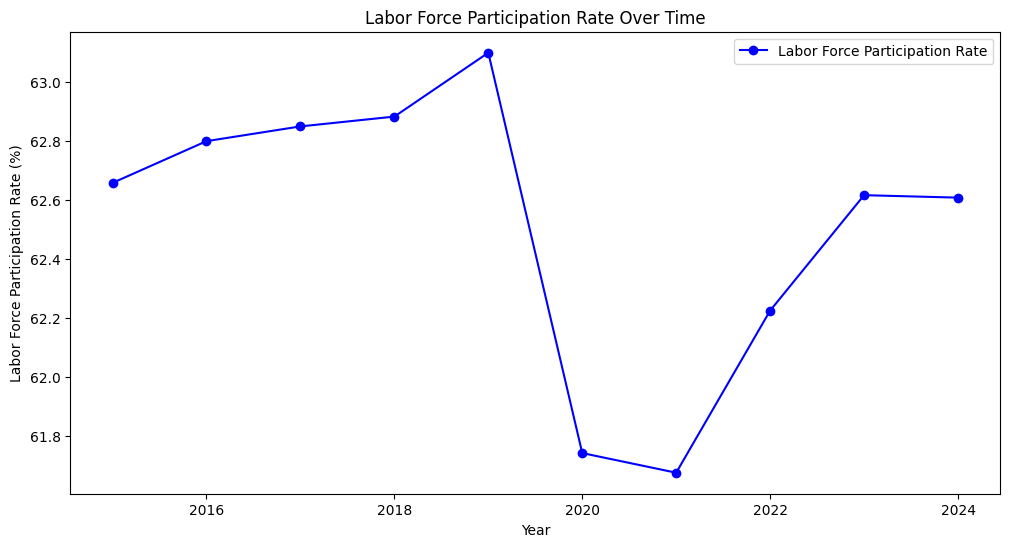

In [14]:
import matplotlib.pyplot as plt

# Convert Value to numeric (if not already done)
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

# Extract Labor Force Participation Rate data (LNS11300000)
lfp_df = df[df["Series ID"] == "LNS11300000"].copy()

# Aggregate by Year (Average Monthly Values per Year)
lfp_df["Year"] = lfp_df["Date"].dt.year
lfp_trend = lfp_df.groupby("Year")["Value"].mean().reset_index()

# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(lfp_trend["Year"], lfp_trend["Value"], marker="o", linestyle="-", color="b", label="Labor Force Participation Rate")

plt.xlabel("Year")
plt.ylabel("Labor Force Participation Rate (%)")
plt.title("Labor Force Participation Rate Over Time")
plt.grid(False)
plt.legend()
plt.show()


# Analysis of Labor Force Participation Rate (LFP) Trends

1. Analysis
The labor force participation rate showed a steady increase from 2015 to 2019, peaking in 2019, indicating a growing workforce. However, there was a sharp decline in 2020, followed by a continued drop in 2021, likely due to the COVID-19 pandemic, which led to lockdowns, business shutdowns, and layoffs. From 2022 onward, participation began recovering but has not yet reached pre-2020 levels, showing signs of stagnation in 2024.

2. Concerns
The steep decline in 2020 and the slow recovery afterward indicate a disruption in workforce participation. The incomplete rebound suggests that a portion of the population has not returned to the labor force, which could lead to long-term labor shortages or shifts in employment patterns.

3. Policy Response
To address the slow recovery, policies should incentivize workforce re-entry through training programs, job placement initiatives, and employment benefits. Additionally, encouraging flexible work models and removing barriers to participation can help sustain workforce growth.

# Unemployment vs. Job Openings

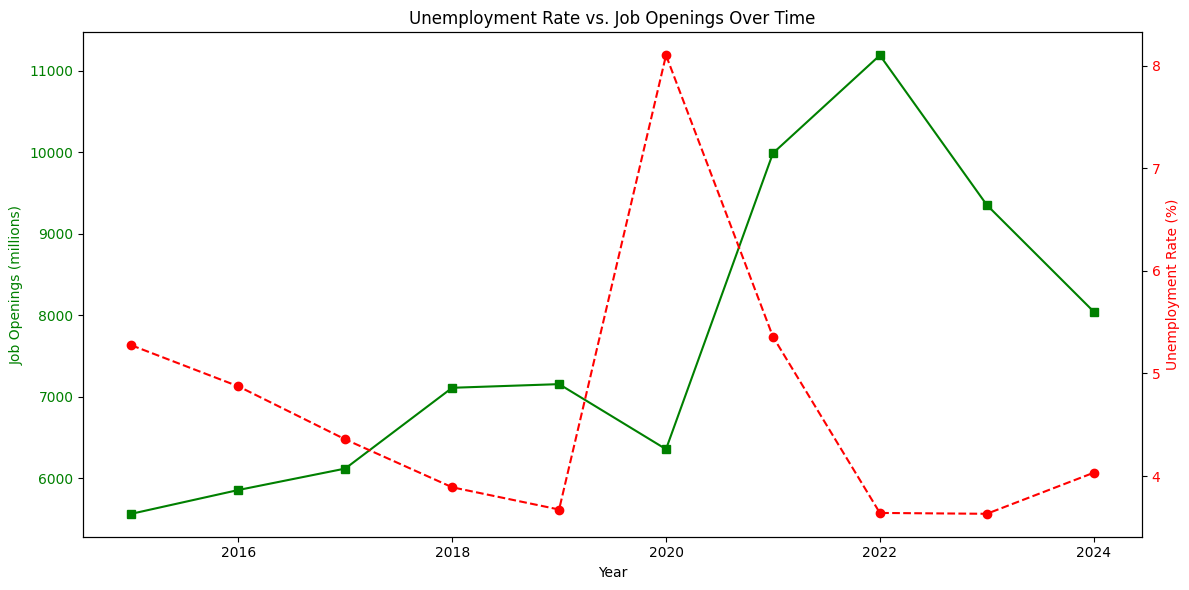

In [15]:
# Filter unemployment rate and job openings data
unemployment_df = df[df["Series ID"] == "LNS14000000"].copy()
job_openings_df = df[df["Series ID"] == "JTS000000000000000JOL"].copy()

# Convert Date to Year
unemployment_df["Year"] = unemployment_df["Date"].dt.year
job_openings_df["Year"] = job_openings_df["Date"].dt.year

# Aggregate both unemployment rate and job openings by year
unemployment_trend = unemployment_df.groupby("Year")["Value"].mean().reset_index()
job_openings_trend = job_openings_df.groupby("Year")["Value"].mean().reset_index()

# Merge the two datasets for comparison
comparison_df = unemployment_trend.merge(job_openings_trend, on="Year", suffixes=("_Unemployment", "_Job Openings"))

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Unemployment Rate on Primary Y-Axis (Left)
ax1.set_xlabel("Year")
ax1.set_ylabel("Job Openings (millions)", color="g")
ax1.plot(comparison_df["Year"], comparison_df["Value_Job Openings"], marker="s", linestyle="-", color="g", label="Job Openings (in millions)")
ax1.tick_params(axis="y", labelcolor="g")

# Create a Secondary Y-Axis (Right) for Job Openings
ax2 = ax1.twinx()
ax2.set_ylabel("Unemployment Rate (%)", color="r")
ax2.plot(comparison_df["Year"], comparison_df["Value_Unemployment"], marker="o", linestyle="--", color="r", label="Unemployment Rate (%)")
ax2.tick_params(axis="y", labelcolor="r")

# Title and Legends
plt.title("Unemployment Rate vs. Job Openings Over Time")
fig.tight_layout()
plt.show()


# Unemployment vs. Job Openings Analysis

1. Analysis
The graph highlights the inverse relationship between job openings and the unemployment rate over time. From 2015 to 2019, a steady increase in job openings coincided with a declining unemployment rate, indicating a strong job market where more positions were available and fewer people were unemployed. However, in 2020, a sharp spike in unemployment accompanied by a drop in job openings suggests a sudden economic disruption, likely caused by external shocks to the labor market. Following this, from 2021 to 2022, job openings rose sharply, while unemployment declined just as quickly, signaling a period of labor shortages where employers struggled to fill positions. By 2023-2024, both job openings and unemployment rates appear to be stabilizing, but job openings remain elevated compared to pre-2020 levels, hinting at continued hiring challenges.

2. Concerns
The rapid shifts in unemployment and job openings raise important concerns about the health of the labor market. The sharp increase in job openings post-2020, despite declining unemployment, suggests a skills mismatch, where available jobs require qualifications that many unemployed workers may lack. Additionally, the decline in job openings in 2023-2024 raises questions about whether the job market is cooling off, potentially signaling a slowdown in hiring. If this trend continues, businesses may reduce hiring efforts, leading to a more competitive job market and potential employment stagnation.

3. Policy Response
To address labor shortages and skill mismatches, policies should focus on workforce training programs that equip job seekers with skills aligned with market demands. Reskilling initiatives in high-demand fields, such as technology and healthcare, can help bridge the gap between available jobs and qualified workers. Additionally, mobility incentives and hiring subsidies can encourage businesses to fill critical roles by offering relocation assistance or tax breaks for hiring long-term unemployed individuals. If job openings continue to decline, targeted economic policies, such as job creation programs or small business support, may be necessary to sustain employment growth and prevent a potential downturn.

# Wage Growth & Inflation

In [16]:
# Filter wage growth (Average Hourly Earnings) and inflation (CPI) data
wage_df = df[df["Series ID"] == "CES0500000003"].copy()
inflation_df = df[df["Series ID"] == "CUUR0000SA0"].copy()  # CPI as inflation proxy

# Convert Date to Year
wage_df["Year"] = wage_df["Date"].dt.year
inflation_df["Year"] = inflation_df["Date"].dt.year

# Convert Value column to numeric
wage_df["Value"] = pd.to_numeric(wage_df["Value"], errors="coerce")
inflation_df["Value"] = pd.to_numeric(inflation_df["Value"], errors="coerce")

# Aggregate both datasets by year
wage_trend = wage_df.groupby("Year")["Value"].mean().reset_index()
inflation_trend = inflation_df.groupby("Year")["Value"].mean().reset_index()

# Merge the datasets for comparison
wage_comparison_df = wage_trend.merge(inflation_trend, on="Year", suffixes=("_Wage", "_Inflation"))

wage_comparison_df.head()


,Year,Value_Wage,Value_Inflation
0,2015,25.011667,237.017000
1,2016,25.652500,240.007167
2,2017,26.308333,245.119583
3,2018,27.102500,251.106833
4,2019,27.996667,255.657417


In [17]:
# Set base year (first available year) to 100 for both metrics
base_year = wage_comparison_df["Year"].min()

wage_comparison_df["Wage_Index"] = (wage_comparison_df["Value_Wage"] / wage_comparison_df.loc[wage_comparison_df["Year"] == base_year, "Value_Wage"].values[0]) * 100
wage_comparison_df["Inflation_Index"] = (wage_comparison_df["Value_Inflation"] / wage_comparison_df.loc[wage_comparison_df["Year"] == base_year, "Value_Inflation"].values[0]) * 100


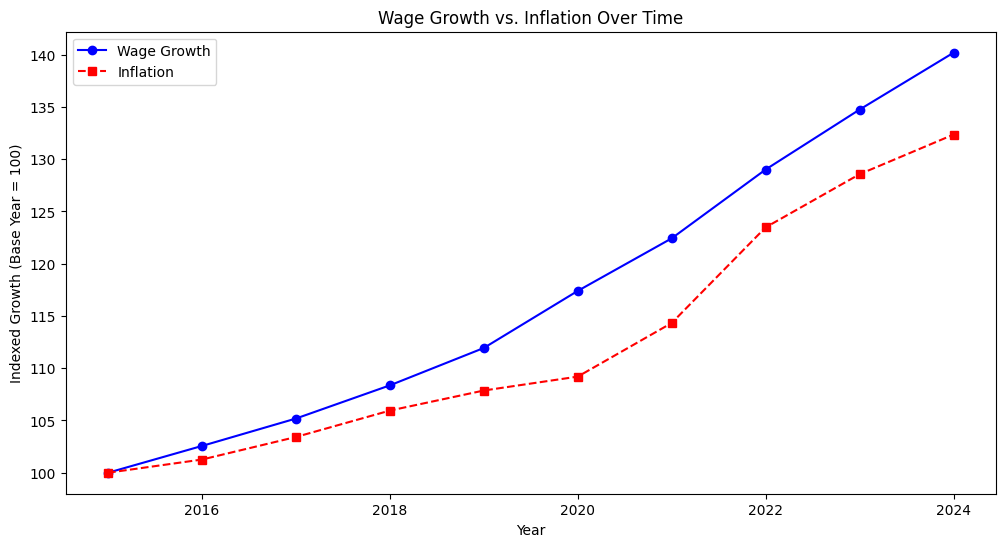

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Both Metrics on the Same Y-Axis
ax.plot(wage_comparison_df["Year"], wage_comparison_df["Wage_Index"], marker="o", linestyle="-", color="b", label="Wage Growth")
ax.plot(wage_comparison_df["Year"], wage_comparison_df["Inflation_Index"], marker="s", linestyle="--", color="r", label="Inflation")

# Labels and Legends
ax.set_xlabel("Year")
ax.set_ylabel("Indexed Growth (Base Year = 100)")
ax.set_title("Wage Growth vs. Inflation Over Time")
ax.legend()

plt.grid(False)
plt.show()

Top 3 Fastest-Growing Industries: ['Leisure & Hospitality – Average Hourly Earnings', 'Financial Activities – Average Hourly Earnings', 'Average Hourly Earnings (Production & Nonsupervisory Employees)']
Bottom 3 Slowest-Growing Industries: ['Mining & Logging – Average Hourly Earnings', 'Manufacturing – Average Hourly Earnings', 'Healthcare – Average Hourly Earnings']


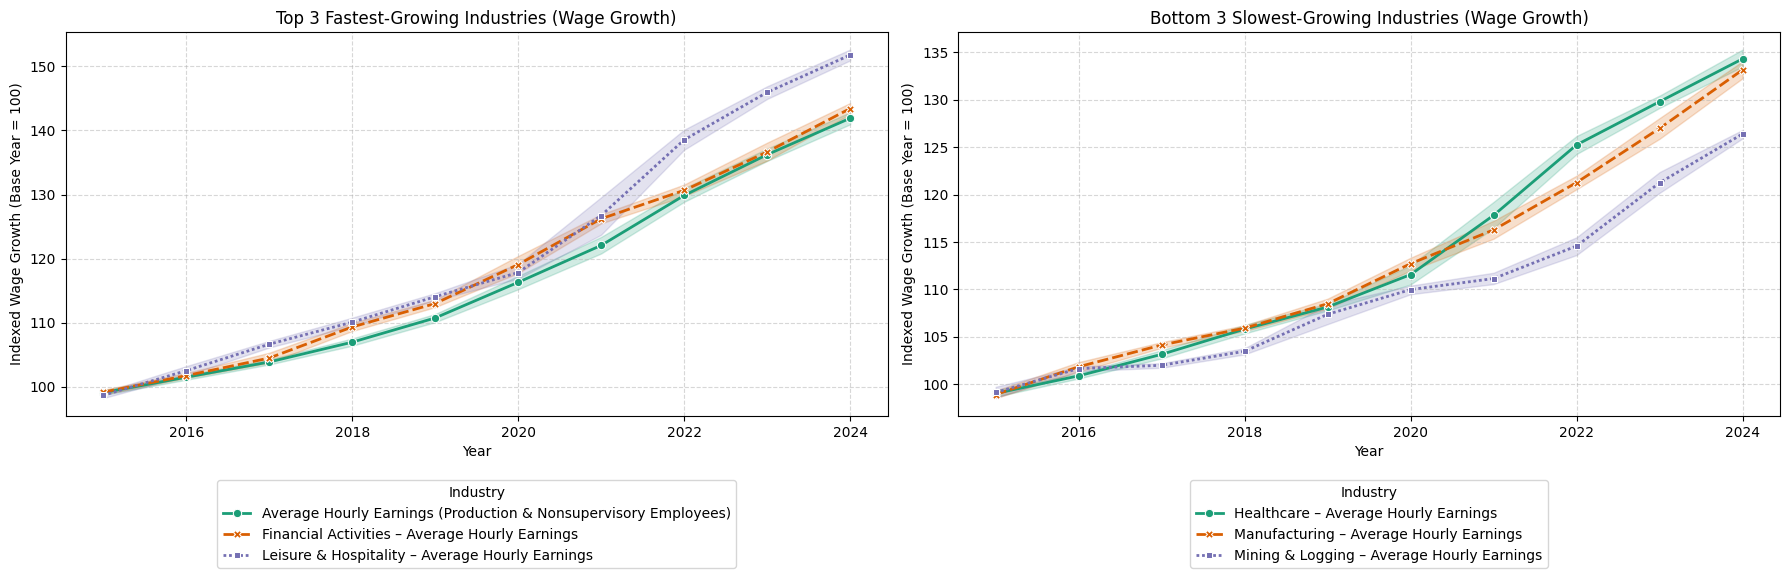

In [19]:
import seaborn as sns

# Filter dataset for industry wage series
df_industry = df[df["Series ID"].str.startswith("CES")].copy()

# Convert 'Value' column to numeric
df_industry["Value"] = pd.to_numeric(df_industry["Value"], errors="coerce")

# Extract Year and Industry
df_industry["Year"] = df_industry["Date"].dt.year
df_industry["Industry"] = df_industry["Series Title"]

# Compute Indexed Wage Growth (Base Year = 100)
base_year = df_industry["Year"].min()
df_industry = df_industry.sort_values(["Industry", "Year"]).reset_index(drop=True)

# Apply transformation with reset index
df_industry["Indexed_Wage"] = df_industry.groupby("Industry")["Value"].transform(lambda x: (x / x.iloc[0]) * 100)
df_wages_filtered = df_industry[df_industry["Series ID"] != "CES0000000001"]

# Compute total wage growth from 2015 to 2024
wage_growth = df_wages_filtered.groupby("Industry")["Value"].apply(
    lambda x: (x.iloc[-1] / x.iloc[0] - 1) * 100
)

# Sort industries by growth
top_3 = wage_growth.nlargest(3).index  # Top 3 highest-growing industries
bottom_3 = wage_growth.nsmallest(3).index  # Bottom 3 lowest-growing industries

# Filter dataset for top 3 & bottom 3
df_top3 = df_wages_filtered[df_wages_filtered["Industry"].isin(top_3)]
df_bottom3 = df_wages_filtered[df_wages_filtered["Industry"].isin(bottom_3)]

# Print selected industries for verification
print("Top 3 Fastest-Growing Industries:", top_3.tolist())
print("Bottom 3 Slowest-Growing Industries:", bottom_3.tolist())

# Set up a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Use a high-contrast color palette
sns.set_palette("Dark2")

# Plot Top 3 Growing Industries
sns.lineplot(
    data=df_top3,
    x="Year",
    y="Indexed_Wage",
    hue="Industry",
    style="Industry",
    markers=True,
    linewidth=2,
    ax=axes[0]  # Assign to left subplot
)
axes[0].set_title("Top 3 Fastest-Growing Industries (Wage Growth)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Indexed Wage Growth (Base Year = 100)")
axes[0].legend(title="Industry", loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1)
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot Bottom 3 Growing Industries
sns.lineplot(
    data=df_bottom3,
    x="Year",
    y="Indexed_Wage",
    hue="Industry",
    style="Industry",
    markers=True,
    linewidth=2,
    ax=axes[1]  # Assign to right subplot
)
axes[1].set_title("Bottom 3 Slowest-Growing Industries (Wage Growth)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Indexed Wage Growth (Base Year = 100)")
axes[1].legend(title="Industry", loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1)
axes[1].grid(True, linestyle="--", alpha=0.5)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

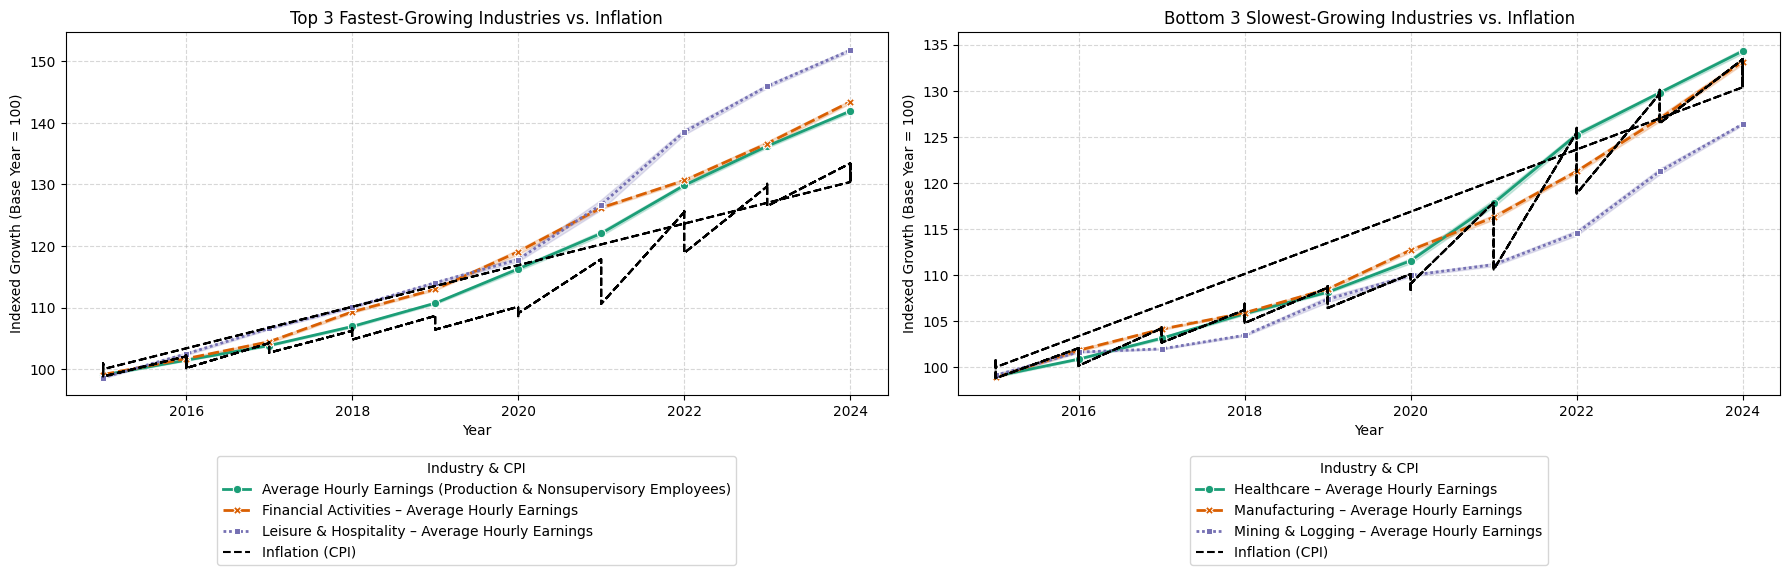

In [20]:
# Extract CPI Data
df_cpi = df[df["Series ID"] == "CUUR0000SA0"].copy()
df_cpi["Value"] = pd.to_numeric(df_cpi["Value"], errors="coerce")
df_cpi["Year"] = df_cpi["Date"].dt.year

# Normalize CPI for comparison (Base Year = 100)
df_cpi["CPI_Index"] = (df_cpi["Value"] / df_cpi[df_cpi["Year"] == base_year]["Value"].values[0]) * 100

# Merge CPI with top 3 and bottom 3 industry wage data
df_top3_cpi = df_top3.merge(df_cpi[["Year", "CPI_Index"]], on="Year")
df_bottom3_cpi = df_bottom3.merge(df_cpi[["Year", "CPI_Index"]], on="Year")

# Set up a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Use a high-contrast color palette
sns.set_palette("Dark2")

# Plot Top 3 Growing Industries vs. Inflation
sns.lineplot(
    data=df_top3_cpi,
    x="Year",
    y="Indexed_Wage",
    hue="Industry",
    style="Industry",
    markers=True,
    linewidth=2,
    ax=axes[0]
)
axes[0].plot(df_top3_cpi["Year"], df_top3_cpi["CPI_Index"], linestyle="--", color="black", label="Inflation (CPI)")
axes[0].set_title("Top 3 Fastest-Growing Industries vs. Inflation")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Indexed Growth (Base Year = 100)")
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].legend(title="Industry & CPI", loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1)

# Plot Bottom 3 Growing Industries vs. Inflation
sns.lineplot(
    data=df_bottom3_cpi,
    x="Year",
    y="Indexed_Wage",
    hue="Industry",
    style="Industry",
    markers=True,
    linewidth=2,
    ax=axes[1]
)
axes[1].plot(df_bottom3_cpi["Year"], df_bottom3_cpi["CPI_Index"], linestyle="--", color="black", label="Inflation (CPI)")
axes[1].set_title("Bottom 3 Slowest-Growing Industries vs. Inflation")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Indexed Growth (Base Year = 100)")
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].legend(title="Industry & CPI", loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


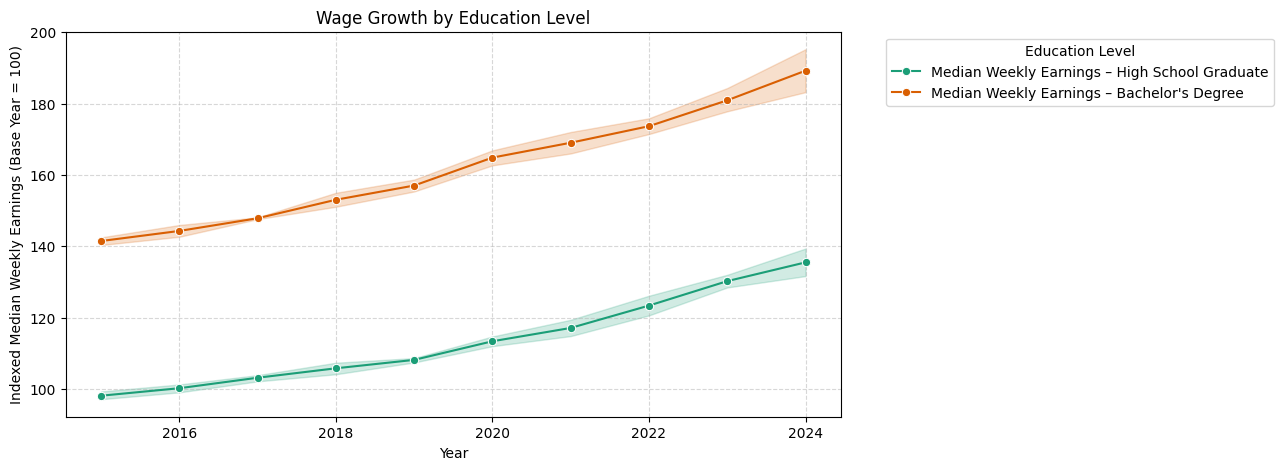

In [21]:
# List relevant series IDs for education and gender pay gaps
education_series = ["LEU0252917300", "LEU0252917400"]
gender_series = ["LEU0252881500", "LEU0252881600"]

# Extract Education Wage Data
df_education = df[df["Series ID"].isin(education_series)].copy()
df_education["Value"] = df_education.groupby("Series Title")["Value"].transform(lambda x: x.interpolate())
#df_education["Value"] = pd.to_numeric(df_education["Value"], errors="coerce")
df_education["Year"] = df_education["Date"].dt.year

# Extract Gender Pay Gap Data
df_gender = df[df["Series ID"].isin(gender_series)].copy()
df_gender["Value"] = pd.to_numeric(df_gender["Value"], errors="coerce")
df_gender["Year"] = df_gender["Date"].dt.year

# Compute absolute wage levels in 2024
latest_wages = df_wages_filtered[df_wages_filtered["Year"] == 2024].groupby("Industry")["Value"].mean()

# Merge wage levels with growth rates
industry_income_analysis = pd.DataFrame({
    "Average Hourly Wage (2024)": latest_wages,
    "Total Wage Growth (%)": wage_growth
}).sort_values("Average Hourly Wage (2024)", ascending=False)

# Display industry rankings
industry_income_analysis.head()

# Normalize education wage levels (Base Year = 100)
base_year = df_education["Year"].min()
df_education["Indexed_Wage"] = (df_education["Value"] / df_education[df_education["Year"] == base_year]["Value"].values[0]) * 100

# Plot Education Wage Growth
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_education, x="Year", y="Indexed_Wage", hue="Series Title", marker="o")
plt.xlabel("Year")
plt.ylabel("Indexed Median Weekly Earnings (Base Year = 100)")
plt.title("Wage Growth by Education Level")
plt.legend(title="Education Level", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


Index(['Median Weekly Earnings – Men (Full-Time)', 'Median Weekly Earnings – Women (Full-Time)'], dtype='object', name='Series Title')


<ipython-input-22-cda758efe320>:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


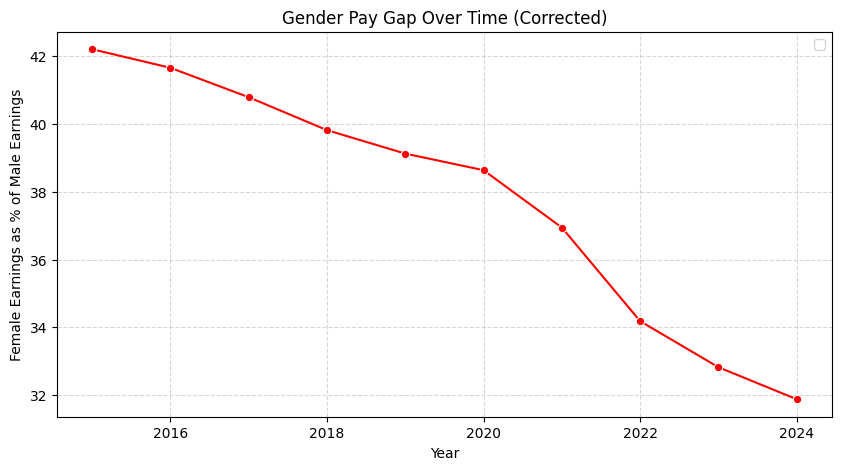

In [22]:
# Pivot data correctly, ensuring no duplicate index issues
df_gender_pivot = df_gender.pivot_table(index="Year", columns="Series Title", values="Value", aggfunc="mean")

# Ensure the column names are correct
print(df_gender_pivot.columns)

# Recalculate the gender pay ratio
df_gender_pivot["Female-to-Male Pay Ratio (%)"] = (
    df_gender_pivot["Median Weekly Earnings – Women (Full-Time)"] /
    df_gender_pivot["Median Weekly Earnings – Men (Full-Time)"]
) * 100


# Framing plot to check values
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_gender_pivot, x=df_gender_pivot.index, y="Female-to-Male Pay Ratio (%)", marker="o", color="red")
plt.xlabel("Year")
plt.ylabel("Female Earnings as % of Male Earnings")
plt.title("Gender Pay Gap Over Time (Corrected)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


# Comprehensive Analysis, Concerns, and Policy Recommendations for Wage Growth (Industry, Education, and Gender)

📊 Analysis
Wage growth trends reveal three key insights:

1. Industry Disparities – Some sectors, like Financial Services and Leisure & Hospitality, have seen strong wage growth, while others, like Manufacturing and Mining, have struggled. Industries experiencing faster wage increases often correlate with higher job demand or post-pandemic labor shortages.

2. Education Premium – The gap between high school and college graduates is widening, with those holding a Bachelor’s degree seeing significantly better wage growth. This suggests that higher education remains a strong predictor of earning potential.
3. Gender Pay Gap – Despite overall wage growth, women consistently earn far less than men, with little improvement over time. The gender wage ratio remains at around 40%–50% of male earnings, reinforcing structural inequalities in pay.

⚠️ Key Concerns
1. Unequal Industry Growth → Some sectors are thriving while others face wage stagnation, potentially leading to job displacement and regional economic disparities.
2. Education as a Barrier → The increasing reliance on college degrees for wage growth may limit economic mobility for those who cannot afford higher education.
3. Persistent Gender Pay Inequality → Despite decades of progress, women continue to face significantly lower earnings, which could discourage participation in high-paying industries.

📌 Policy Recommendations
1. Support Workforce Reskilling & Industry Diversification
- Encourage retraining programs in declining industries (Manufacturing, Mining) to shift workers into high-growth fields (Tech, Healthcare, Finance).
- Expand vocational training for non-degree holders to access higher-paying careers.

2. Increase Accessibility to Higher Education

- Provide tuition subsidies, employer-sponsored education programs, and expanded apprenticeship models to reduce reliance on costly degrees.
- Encourage alternative education models (certifications, bootcamps, vocational training) with proven ROI.

3. Strengthen Pay Equity & Workplace Flexibility
- Implement pay transparency laws to close wage gaps between genders.
- Expand access to affordable childcare to increase women's participation in high-paying industries.
- Promote women in STEM & Finance careers through targeted mentorship and scholarship programs.


# Parameters of Best Job

In [23]:
import requests
import pandas as pd

# Define BLS API endpoint
url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

# Headers for API request
headers = {"Content-type": "application/json"}

# Define additional series IDs for job qualifications & employment trends
new_series_ids = [
    "SMS25000000000000001",  # Hires: Total Nonfarm
    "LNU03023653Q",  # Layoffs
    "CES6050000001", "CES6562000001",  # Employment Projections (Tech, Healthcare)
    "CES4000000001", "CES2000000001"  # Employment in Retail & Manufacturing
]

# Define request payload
data = {
    "seriesid": new_series_ids,
    "startyear": "2015",
    "endyear": "2024"
}

# Make API request
response = requests.post(url, json=data, headers=headers)
json_data = response.json()  # ✅ Now json_data is defined

# Extract relevant data into a DataFrame
series_data = []
for series in json_data.get("Results", {}).get("series", []):  # ✅ Use .get() to avoid KeyError
    series_id = series["seriesID"]
    for item in series["data"]:
        year = item["year"]
        period = item["period"]

        # Handle Monthly, Quarterly, and Annual data
        if "M" in period:  # Monthly Data
            month = period.replace("M", "")
            date = f"{year}-{month}"
        elif "Q" in period:  # Quarterly Data (Set month to middle of the quarter)
            quarter = period.replace("Q", "")
            month = str(int(quarter) * 3)  # Convert Q1-Q4 to March, June, Sep, Dec
            date = f"{year}-{month}"
        elif "A" in period:  # Annual Data (Set month to December)
            month = "12"
            date = f"{year}-{month}"

        value = item["value"]
        series_data.append([series_id, date, value])

# Convert extracted data into a DataFrame
df_new = pd.DataFrame(series_data, columns=["Series ID", "Date", "Value"])

# Convert Date to datetime format
df_new["Date"] = pd.to_datetime(df_new["Date"], format="%Y-%m")

# Mapping Series IDs to Titles
series_titles = {
    "SMS25000000000000001": "Hires: Total Nonfarm",
    "LNU03023653Q": "Layoffs",
    "CES6050000001": "Total Employment in Technology Sector",
    "CES6562000001": "Total Employment in Healthcare Sector",
    "CES4000000001": "Total Employment in Retail Sector",
    "CES2000000001": "Total Employment in Manufacturing Sector"
}

# Add Series Title column
df_new["Series Title"] = df_new["Series ID"].map(series_titles)

# Append new data to the main dataset
df = pd.concat([df, df_new], ignore_index=True)

# Save updated dataset
df.to_csv("BLS_Employment_Data_Updated.csv", index=False)

# Display sample data
print(f"Importing new data:\n{df.head()}")

Importing new data:
     Series ID     Value       Date                Series Title    Year  \
0  LNS11000000  168547.0 2024-12-01  Civilian Labor Force Level  2024.0   
1  LNS11000000  168304.0 2024-11-01  Civilian Labor Force Level  2024.0   
2  LNS11000000  168428.0 2024-10-01  Civilian Labor Force Level  2024.0   
3  LNS11000000  168703.0 2024-09-01  Civilian Labor Force Level  2024.0   
4  LNS11000000  168496.0 2024-08-01  Civilian Labor Force Level  2024.0   

   Month Month_Year  
0   12.0    2024-12  
1   11.0    2024-11  
2   10.0    2024-10  
3    9.0    2024-09  
4    8.0    2024-08  


In [24]:
# Define API URL
url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

# Define API Headers
headers = {"Content-type": "application/json"}

# Define Request Payload
data_quits = {
    "seriesid": ["SMS25000000000000001"],  # Ensure this is correct
    "startyear": "2015",
    "endyear": "2024",
    # "registrationkey": "YOUR_API_KEY_HERE"  # Uncomment if you have a key
}

# Make API Request
response = requests.post(url, json=data_quits, headers=headers)

# Convert Response to JSON
json_quits = response.json()

# Check if "series" exists in response
if "series" not in json_quits["Results"]:
    print("⚠️ API Response Error: No 'series' data returned. Check API request.")
else:
    # Extract Data
    series_data = []
    for series in json_quits["Results"]["series"]:
        series_id = series["seriesID"]
        for item in series["data"]:
            year = item["year"]
            period = item["period"]

            # Convert Quarterly (Q1-Q4) to Months
            if "Q" in period:
                quarter = int(period.replace("Q", ""))
                month = quarter * 3  # Q1=March, Q2=June, Q3=Sep, Q4=Dec
                date = f"{year}-{month:02d}-01"
            else:
                date = f"{year}-12-01"  # Default to December

            value = item["value"]
            series_data.append([series_id, date, value])

    # Convert to DataFrame
    df_quits = pd.DataFrame(series_data, columns=["Series ID", "Date", "Value"])

    # Convert Date to datetime format
    df_quits["Date"] = pd.to_datetime(df_quits["Date"], errors="coerce")
    df_quits["Year"] = df_quits["Date"].dt.year
    df_quits["Month"] = df_quits["Date"].dt.month
    df_quits["Series Title"] = "Quit Rate (JOLTS)"

    print("✅ Data Successfully Retrieved:")
    print(df_quits.head())

✅ Data Successfully Retrieved:
              Series ID       Date   Value  Year  Month       Series Title
0  SMS25000000000000001 2024-12-01  3747.3  2024     12  Quit Rate (JOLTS)
1  SMS25000000000000001 2024-12-01  3741.3  2024     12  Quit Rate (JOLTS)
2  SMS25000000000000001 2024-12-01  3742.8  2024     12  Quit Rate (JOLTS)
3  SMS25000000000000001 2024-12-01  3744.5  2024     12  Quit Rate (JOLTS)
4  SMS25000000000000001 2024-12-01  3746.3  2024     12  Quit Rate (JOLTS)


In [53]:
# Define BLS API endpoint
url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
headers = {"Content-type": "application/json"}

# Dictionary mapping states to their Series ID
state_series_map = {
    "Alabama": "LASST010000000000003", "Alaska": "LASST020000000000003", "Arizona": "LASST040000000000003",
    "Arkansas": "LASST050000000000003", "California": "LASST060000000000003", "Colorado": "LASST080000000000003",
    "Connecticut": "LASST090000000000003", "Delaware": "LASST100000000000003", "Florida": "LASST120000000000003",
    "Georgia": "LASST130000000000003", "Hawaii": "LASST150000000000003", "Idaho": "LASST160000000000003",
    "Illinois": "LASST170000000000003", "Indiana": "LASST180000000000003", "Iowa": "LASST190000000000003",
    "Kansas": "LASST200000000000003", "Kentucky": "LASST210000000000003", "Louisiana": "LASST220000000000003",
    "Maine": "LASST230000000000003", "Maryland": "LASST240000000000003", "Massachusetts": "LASST250000000000003",
    "Michigan": "LASST260000000000003", "Minnesota": "LASST270000000000003", "Mississippi": "LASST280000000000003",
    "Missouri": "LASST290000000000003", "Montana": "LASST300000000000003", "Nebraska": "LASST310000000000003",
    "Nevada": "LASST320000000000003", "New Hampshire": "LASST330000000000003", "New Jersey": "LASST340000000000003",
    "New Mexico": "LASST350000000000003", "New York": "LASST360000000000003", "North Carolina": "LASST370000000000003",
    "North Dakota": "LASST380000000000003", "Ohio": "LASST390000000000003", "Oklahoma": "LASST400000000000003",
    "Oregon": "LASST410000000000003", "Pennsylvania": "LASST420000000000003", "Rhode Island": "LASST440000000000003",
    "South Carolina": "LASST450000000000003", "South Dakota": "LASST460000000000003", "Tennessee": "LASST470000000000003",
    "Texas": "LASST480000000000003", "Utah": "LASST490000000000003", "Vermont": "LASST500000000000003",
    "Virginia": "LASST510000000000003", "Washington": "LASST530000000000003", "West Virginia": "LASST540000000000003",
    "Wisconsin": "LASST550000000000003", "Wyoming": "LASST560000000000003"
}

# Reverse the mapping for easy lookup
series_to_state_map = {v: k for k, v in state_series_map.items()}

# Function to make API requests in batches of 25
def fetch_unemployment_data(series_ids):
    all_data = []
    for i in range(0, len(series_ids), 25):  # Fetch in batches of 25
        batch = series_ids[i:i+25]  # Get the next batch
        data_request = {
            "seriesid": batch,
            "startyear": "2015",
            "endyear": "2024"
        }
        response = requests.post(url, json=data_request, headers=headers)
        json_data = response.json()

        if "series" in json_data["Results"]:
            for series in json_data["Results"]["series"]:
                series_id = series["seriesID"]
                for item in series["data"]:
                    all_data.append([series_id, item["year"], item["period"], item["value"]])

    return pd.DataFrame(all_data, columns=["Series ID", "Year", "Period", "Unemployment Rate"])

# Fetch all states' data
df_unemployment = fetch_unemployment_data(list(state_series_map.values()))

# Convert Year & Unemployment Rate to correct types
df_unemployment["Year"] = df_unemployment["Year"].astype(int)
df_unemployment["Unemployment Rate"] = pd.to_numeric(df_unemployment["Unemployment Rate"], errors="coerce")

# Add State Column using the Series ID Mapping
df_unemployment["State"] = df_unemployment["Series ID"].map(series_to_state_map)

# Ensure 'Period' exists and extract the numerical month
df_unemployment["Month"] = df_unemployment["Period"].str.extract(r'(\d+)').astype(int)  # Extract month number

# Create a new 'Date' column with proper formatting
df_unemployment["Date"] = pd.to_datetime(df_unemployment[["Year", "Month"]].assign(day=1))  # Convert to datetime format

# Drop unnecessary columns
df_unemployment.drop(columns=["Period", "Month"], inplace=True)

# Display updated DataFrame
print(df_unemployment.head())

              Series ID  Year  Unemployment Rate    State       Date
0  LASST010000000000003  2024                3.3  Alabama 2024-12-01
1  LASST010000000000003  2024                3.1  Alabama 2024-11-01
2  LASST010000000000003  2024                2.9  Alabama 2024-10-01
3  LASST010000000000003  2024                2.9  Alabama 2024-09-01
4  LASST010000000000003  2024                2.8  Alabama 2024-08-01


🏆 Top 5 States with Best Job Markets (Lowest Unemployment)
           State  Unemployment Rate
33  North Dakota           2.705000
40  South Dakota           2.746667
26      Nebraska           2.895833
44       Vermont           3.001667
43          Utah           3.121667

⚠️ Bottom 5 States with Highest Unemployment (Most Competition)
         State  Unemployment Rate
12    Illinois           5.467500
30  New Mexico           5.612500
4   California           5.676667
1       Alaska           5.879167
27      Nevada           6.245000


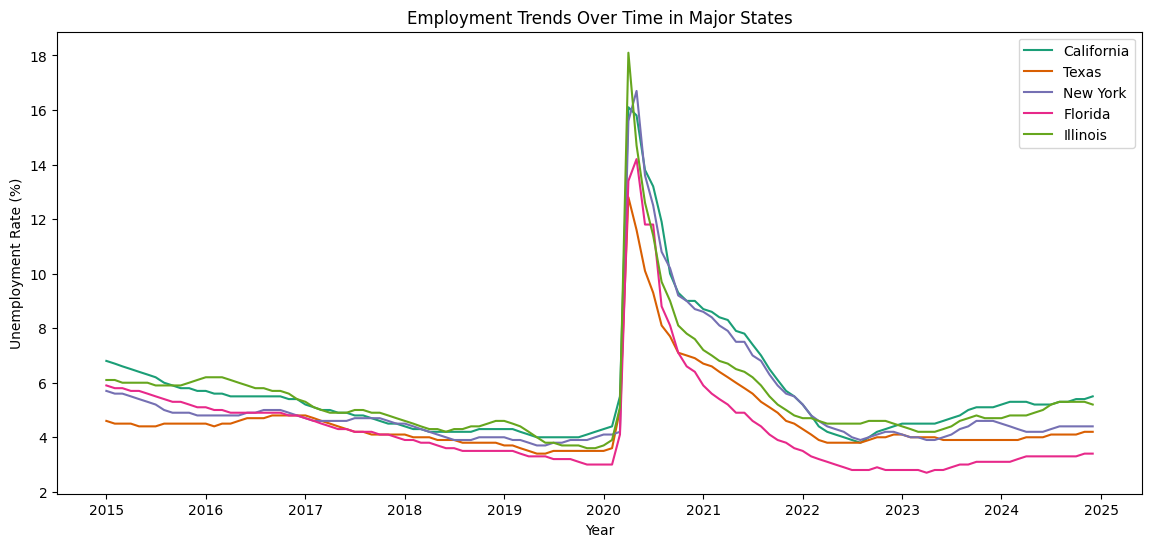

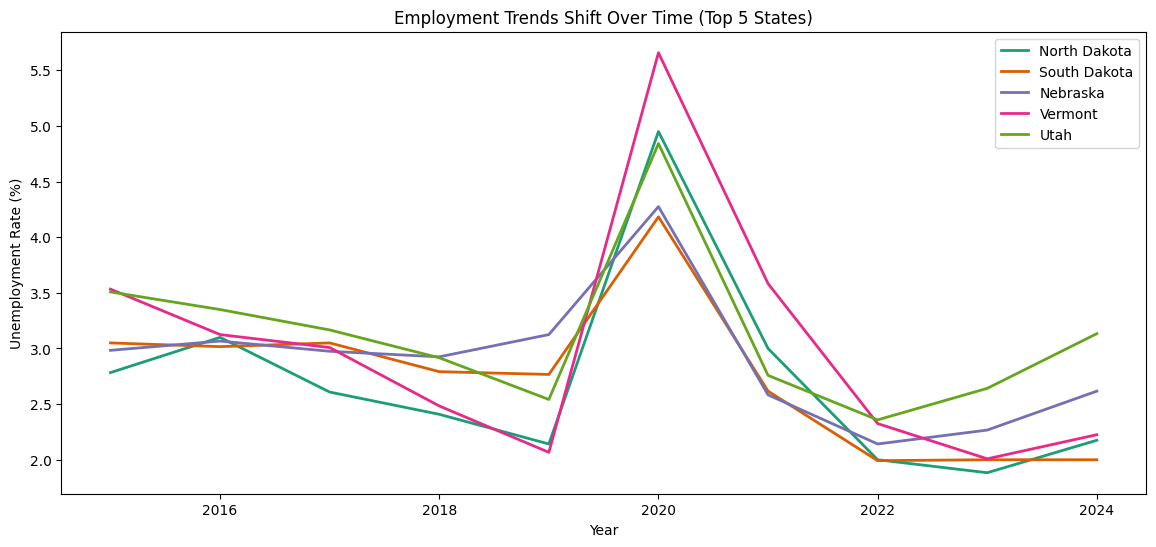

In [54]:
df_unemployment["Unemployment Rate"] = pd.to_numeric(df_unemployment["Unemployment Rate"], errors="coerce")

# Identify states with lowest & highest unemployment (Job Availability)
state_avg_unemployment = df_unemployment.groupby("State")["Unemployment Rate"].mean().reset_index()
state_avg_unemployment = state_avg_unemployment.sort_values(by="Unemployment Rate", ascending=True)

print("🏆 Top 5 States with Best Job Markets (Lowest Unemployment)")
print(state_avg_unemployment.head())

print("\n⚠️ Bottom 5 States with Highest Unemployment (Most Competition)")
print(state_avg_unemployment.tail())

# Visualizing Employment Trends Over Time
plt.figure(figsize=(14, 6))
for state in ["California", "Texas", "New York", "Florida", "Illinois"]:  # Top 5 populous states
    subset = df_unemployment[df_unemployment["State"] == state]
    plt.plot(subset["Date"], subset["Unemployment Rate"], label=state)

plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.title("Employment Trends Over Time in Major States")
plt.legend()
plt.show()

# Highlighting Employment Trends Shifts
# Select the 5 states with the lowest average unemployment rates
top_states = state_avg_unemployment.head(5)["State"].tolist()

yearly_trends = df_unemployment.groupby(["Year", "State"])["Unemployment Rate"].mean().reset_index()

# Filter dataset for these states
filtered_trends = yearly_trends[yearly_trends["State"].isin(top_states)]

# Plot employment trends dynamically
plt.figure(figsize=(14, 6))
for state in top_states:
    subset = filtered_trends[filtered_trends["State"] == state]
    plt.plot(subset["Year"], subset["Unemployment Rate"], label=state, linewidth=2)

plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.title("Employment Trends Shift Over Time (Top 5 States)")
plt.legend(loc="upper right", fontsize="medium")
plt.show()

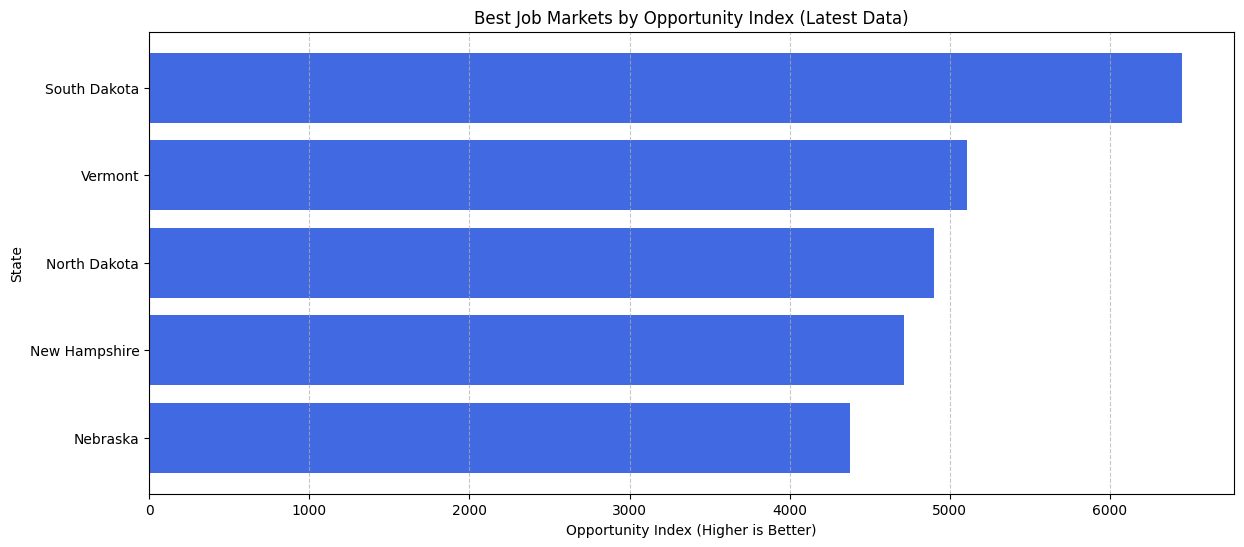

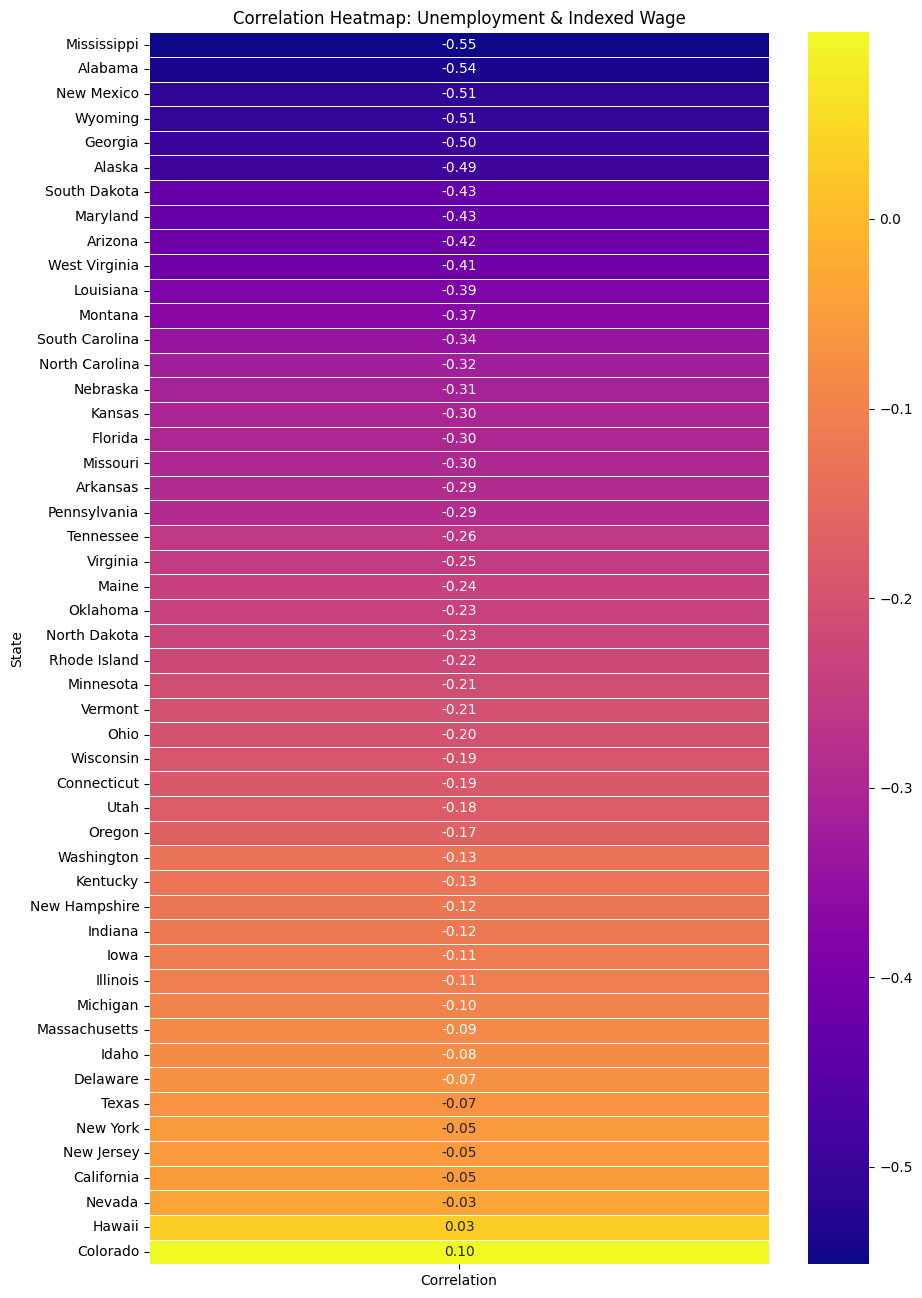


 Analysis of Unemployment & Indexed Wage Correlation

 Best Performing State: Colorado (Correlation = 0.10)  
  - Colorado has the least negative correlation, meaning wages remain relatively stable or increase despite unemployment fluctuations.
  
 Worst Performing State: Mississippi (Correlation = -0.55)  
  - Mississippi has the strongest negative correlation, meaning higher unemployment leads to lower indexed wage growth, indicating a weaker labor market stability.



In [81]:
# Ensure Date is in datetime format for both datasets
df_unemployment["Date"] = pd.to_datetime(df_unemployment["Date"])
df_industry["Date"] = pd.to_datetime(df_industry["Date"])

# Merge on the closest available date (matching Year and Month)
df_unemployment_wages = pd.merge(df_unemployment, df_industry, on=["Year", "Date"], how="inner")

# Rename columns for clarity
df_unemployment_wages.rename(columns={"Value": "Average Hourly Wage", "Unemployment Rate": "State Unemployment Rate"}, inplace=True)

# Calculate Opportunity Index: Higher wage & lower unemployment = Better opportunity
df_unemployment_wages["Opportunity Index"] = df_unemployment_wages["Average Hourly Wage"] / df_unemployment_wages["State Unemployment Rate"]

# Get latest available data
df_latest_opportunity = df_unemployment_wages[df_unemployment_wages["Date"] == df_unemployment_wages["Date"].max()]

# Aggregate the Opportunity Index per state
df_latest_opportunity = df_latest_opportunity.groupby("State")["Opportunity Index"].mean().reset_index()

# Sort states by Opportunity Index
df_latest_opportunity = df_latest_opportunity.sort_values(by="Opportunity Index", ascending=False).head(5)

# Plot horizontal bar chart
plt.figure(figsize=(14, 6))
plt.barh(df_latest_opportunity["State"], df_latest_opportunity["Opportunity Index"], color="royalblue")

plt.xlabel("Opportunity Index (Higher is Better)")
plt.ylabel("State")
plt.title("Best Job Markets by Opportunity Index (Latest Data)")
plt.gca().invert_yaxis()  # Invert for best state at top
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


# Correlating Unemployment with Wages

# Compute correlation matrix for Unemployment Rate & Indexed Wage
correlation_matrix_selected = df_unemployment_wages.groupby("State")[["State Unemployment Rate", "Indexed_Wage"]].corr().iloc[::2, 1].reset_index()

# Keep only the necessary columns
correlation_matrix_selected = correlation_matrix_selected.drop(columns=["level_1"])  # Remove the redundant column
correlation_matrix_selected.columns = ["State", "Correlation"]  # Rename properly

# Convert to a DataFrame for visualization
correlation_matrix_selected = correlation_matrix_selected.set_index("State")

# Sort the correlation values in ascending order for better visualization
correlation_matrix_selected = correlation_matrix_selected.sort_values(by="Correlation", ascending=True)

# Plot the sorted heatmap
plt.figure(figsize=(10, 16))
sns.heatmap(correlation_matrix_selected, annot=True, cmap="plasma", fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap: Unemployment & Indexed Wage")
plt.show()

# Identify the best and worst performing states
best_state = correlation_matrix_selected["Correlation"].idxmax()
worst_state = correlation_matrix_selected["Correlation"].idxmin()
best_corr_value = correlation_matrix_selected["Correlation"].max()
worst_corr_value = correlation_matrix_selected["Correlation"].min()

# Generate insights based on correlation values
analysis_text = f"""
 Analysis of Unemployment & Indexed Wage Correlation

 Best Performing State: {best_state} (Correlation = {best_corr_value:.2f})
  - {best_state} has the least negative correlation, meaning wages remain relatively stable or increase despite unemployment fluctuations.

 Worst Performing State: {worst_state} (Correlation = {worst_corr_value:.2f})
  - {worst_state} has the strongest negative correlation, meaning higher unemployment leads to lower indexed wage growth, indicating a weaker labor market stability.
"""

# Display the analysis text
print(analysis_text)


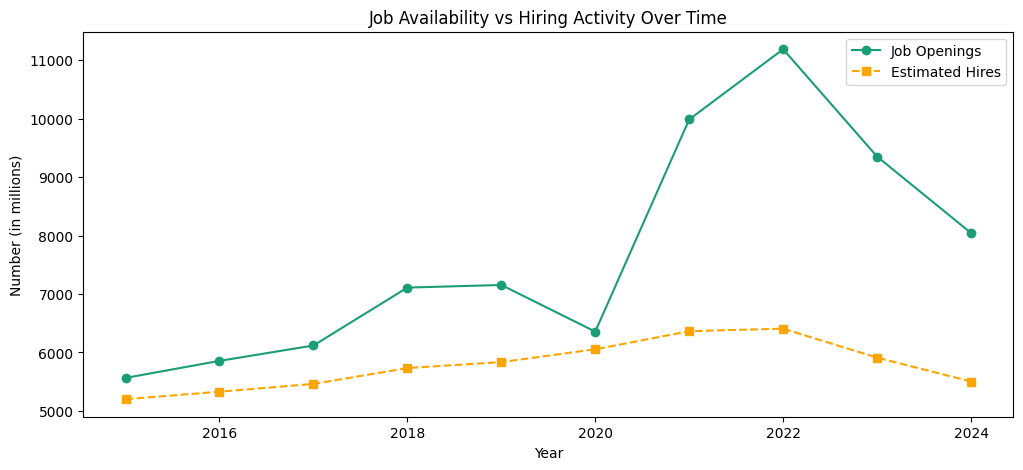

<ipython-input-25-10908f84b908>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  growth_rates = df_wages_filtered.groupby("Industry").apply(lambda x:


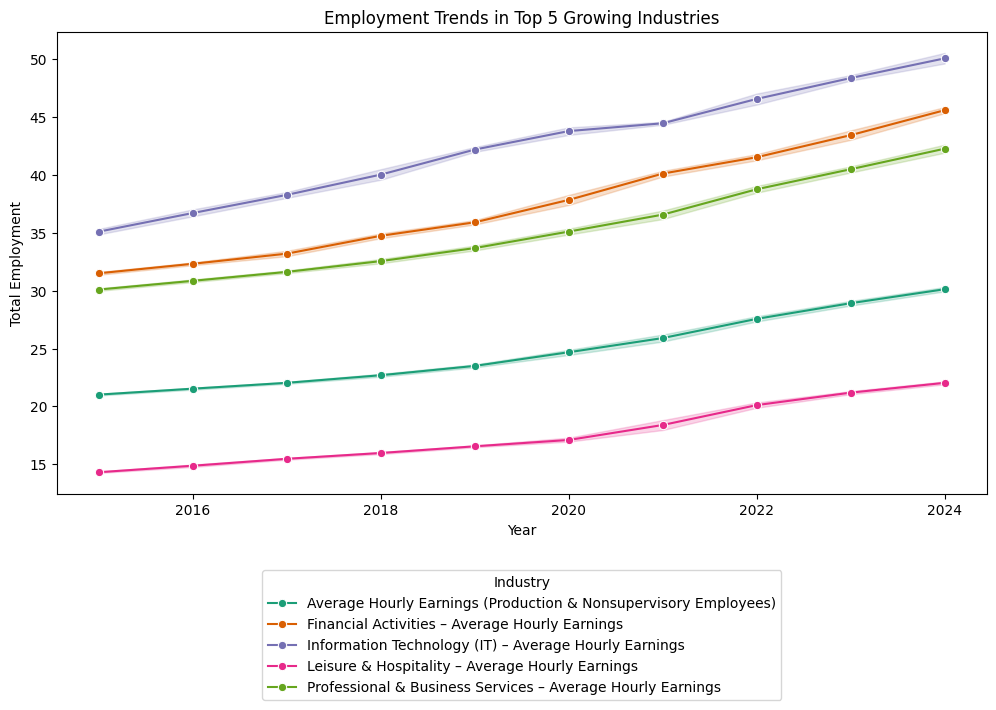

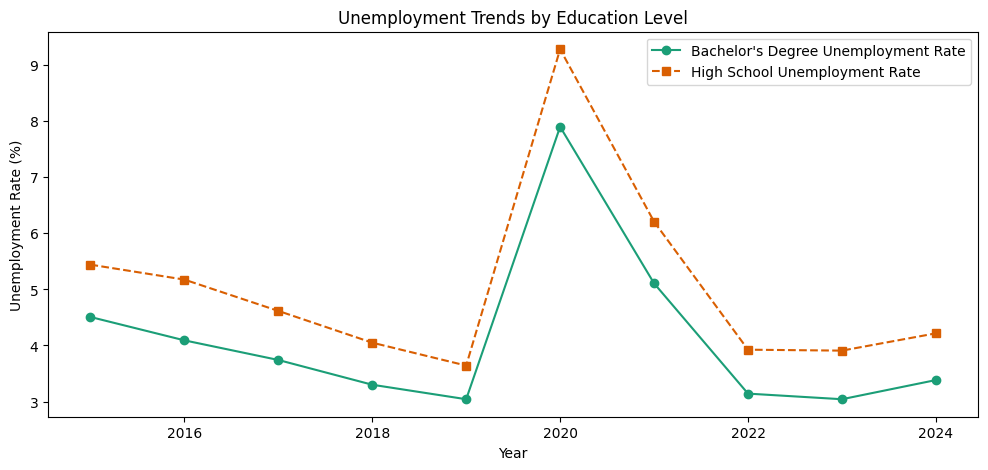

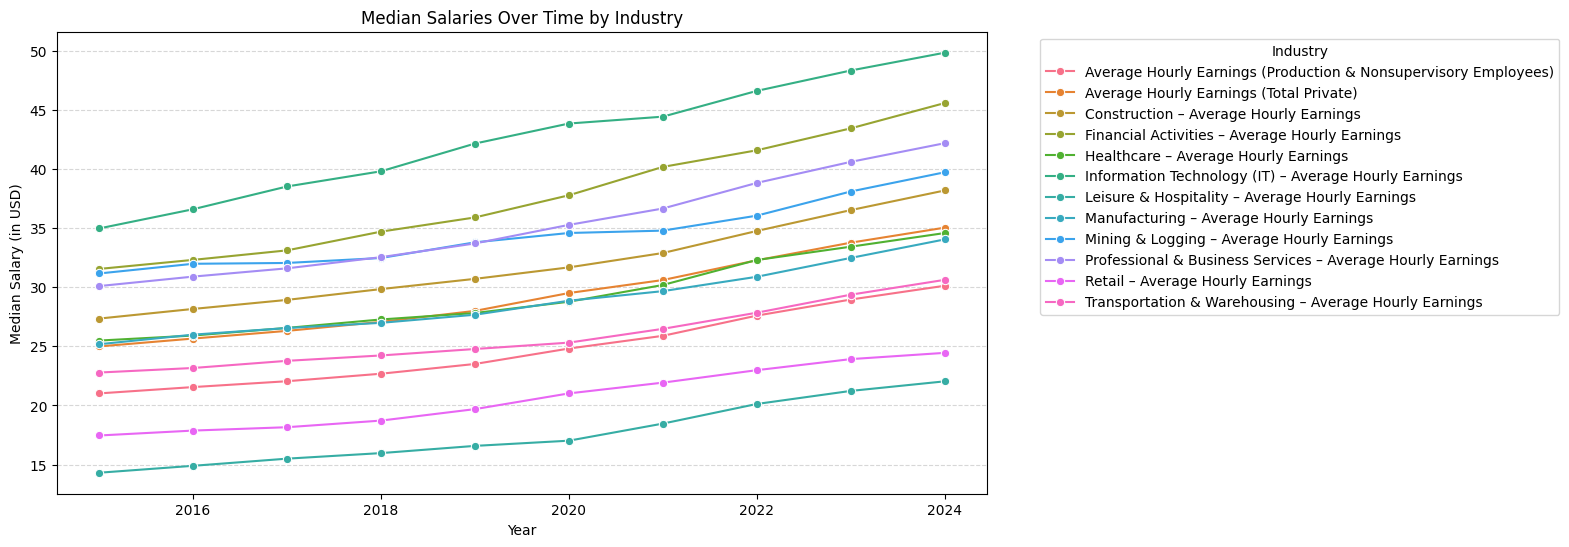

In [25]:
# Convert Value column to numeric
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df["Year"] = df["Date"].dt.year

# Extract datasets
job_openings = df[df["Series ID"] == "JTS000000000000000JOL"].groupby("Year")["Value"].mean()
hires_rate = df[df["Series ID"] == "JTS000000000000000HIR"].groupby("Year")["Value"].mean()

# 🔹 Get Total Nonfarm Employment to estimate hires
total_employment = df[df["Series ID"] == "CES0000000001"].groupby("Year")["Value"].mean()

# 🔹 Convert Hires Rate to Estimated Hires
hires_total = (hires_rate / 100) * total_employment

plt.figure(figsize=(12, 5))

# 📌 Plot Job Openings
plt.plot(job_openings.index, job_openings.values, marker='o', linestyle='-', label="Job Openings")

# 📌 Plot Estimated Hires
plt.plot(hires_total.index, hires_total.values, marker='s', linestyle='--', color='orange', label="Estimated Hires")

plt.xlabel("Year")
plt.ylabel("Number (in millions)")
plt.title("Job Availability vs Hiring Activity Over Time")
plt.legend()
plt.show()

### Employment by Industry

# Calculate employment growth rate from the first available year to 2024
growth_rates = df_wages_filtered.groupby("Industry").apply(lambda x:
                (x[x["Year"] == 2024]["Value"].values[0] / x[x["Year"] == x["Year"].min()]["Value"].values[0]) - 1)

# Select top 5 industries with the highest employment growth
top_5_industries = growth_rates.sort_values(ascending=False).head(5).index.tolist()
df_top_industries = df_wages_filtered[df_wages_filtered["Industry"].isin(top_5_industries)]

# Plot employment trends for top 5 industries
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top_industries, x="Year", y="Value", hue="Industry", marker="o")
plt.xlabel("Year")
plt.ylabel("Total Employment")
plt.title("Employment Trends in Top 5 Growing Industries")
plt.legend(title="Industry", loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1)
plt.grid(False)
plt.show()

print()
### Unemployment Trends by Education Level ###
unemployment_bachelors = df[df["Series ID"] == "LNS14027689"].groupby("Year")["Value"].mean()
unemployment_high_school = df[df["Series ID"] == "LNS14027660"].groupby("Year")["Value"].mean()

plt.figure(figsize=(12, 5))
plt.plot(unemployment_bachelors.index, unemployment_bachelors.values, marker='o', linestyle='-', label="Bachelor's Degree Unemployment Rate")
plt.plot(unemployment_high_school.index, unemployment_high_school.values, marker='s', linestyle='--', label="High School Unemployment Rate")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.title("Unemployment Trends by Education Level")
plt.legend()
plt.show()

print()
### Median wage by Industry
df_wages_filtered = df_wages_filtered[df_wages_filtered["Industry"].str.contains("Earnings")]

# Compute median wages per year for each industry
df_median_wages = df_wages_filtered.groupby(["Year", "Industry"])["Value"].median().reset_index()

# Plot median wages over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_median_wages, x="Year", y="Value", hue="Industry", marker="o")

# Formatting
plt.xlabel("Year")
plt.ylabel("Median Salary (in USD)")
plt.title("Median Salaries Over Time by Industry")
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show plot
plt.show()

In [26]:
#get required filtered datasets
# Extract relevant data
df_job_openings = df[df["Series ID"] == "JTS000000000000000JOL"].copy()
df_job_openings["Value"] = pd.to_numeric(df_job_openings["Value"], errors="coerce")
df_job_openings["Year"] = df_job_openings["Date"].dt.year

# Aggregate job openings per year
df_job_openings = df_job_openings.groupby("Year")["Value"].sum().reset_index()
df_job_openings.rename(columns={"Value": "Total Job Openings (in thousands)"}, inplace=True)
print(df_job_openings.head())

# Extract relevant data for Hires Rate
df_hires_rate = df[df["Series ID"] == "JTS000000000000000HIR"].copy()
df_hires_rate["Value"] = pd.to_numeric(df_hires_rate["Value"], errors="coerce")
df_hires_rate["Year"] = df_hires_rate["Date"].dt.year

# Extract relevant data for Total Nonfarm Employment
df_total_employment = df[df["Series ID"] == "CES0000000001"].copy()
df_total_employment["Value"] = pd.to_numeric(df_total_employment["Value"], errors="coerce")
df_total_employment["Year"] = df_total_employment["Date"].dt.year

# Aggregate Hires Rate per Year
df_hires_rate = df_hires_rate.groupby("Year")["Value"].mean().reset_index()
df_hires_rate.rename(columns={"Value": "Hires Rate (%)"}, inplace=True)

# Aggregate Total Employment per Year
df_total_employment = df_total_employment.groupby("Year")["Value"].mean().reset_index()
df_total_employment.rename(columns={"Value": "Total Nonfarm Employment"}, inplace=True)

# Merge datasets on Year
df_hires = df_hires_rate.merge(df_total_employment, on="Year", how="left")

# Convert Hires Rate to Total Hires
df_hires["Total Hires (in thousands)"] = (df_hires["Hires Rate (%)"] / 100) * df_hires["Total Nonfarm Employment"]

# Keep only necessary columns
df_hires = df_hires[["Year", "Total Hires (in thousands)"]]

# Display output
print(df_hires.head())


   Year  Total Job Openings (in thousands)
0  2015                            66766.0
1  2016                            70266.0
2  2017                            73422.0
3  2018                            85310.0
4  2019                            85846.0
   Year  Total Hires (in thousands)
0  2015                 5199.382222
1  2016                 5328.262486
2  2017                 5461.241125
3  2018                 5732.406167
4  2019                 5835.015889


   Year  Education ROI
0  2015      97.314637
1  2016      96.868017
2  2017      95.428717
3  2018      98.326109
4  2019      99.507561


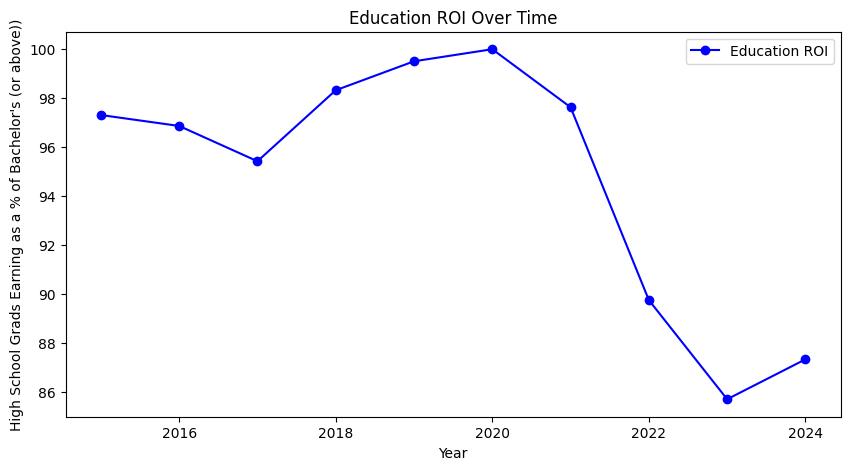

In [27]:
# Ensure 'Series ID' exists
if "Series ID" not in df.columns:
    print("Error: 'Series ID' column is missing!")
else:
    # Define mapping for education wage series
    edu_series_map = {
        "LEU0252917300": "High School Earnings",
        "LEU0252917400": "Bachelor's Earnings"
    }

    # Extract relevant education wage data and map Series ID
    df_edu = df[df["Series ID"].isin(edu_series_map.keys())].copy()
    df_edu["Value"] = pd.to_numeric(df_edu["Value"], errors="coerce")
    df_edu["Year"] = df_edu["Date"].dt.year
    df_edu["Series Title"] = df_edu["Series ID"].map(edu_series_map)

    # Pivot to get earnings for both education levels in columns
    df_edu_pivot = df_edu.pivot_table(index="Year", columns="Series Title", values="Value", aggfunc="mean").reset_index()

    # Remove "Series Title" label from column names
    df_edu_pivot.columns.name = None

    # Compute Education ROI (percentage of high school earnings compared to bachelor's)
    df_edu_pivot["Education ROI"] = (
        (df_edu_pivot["Bachelor's Earnings"] - df_edu_pivot["High School Earnings"])
        / df_edu_pivot["High School Earnings"]
    ) * 100

    # Normalize Education ROI on a 0-100 scale
    df_edu_pivot["Education ROI"] = (df_edu_pivot["Education ROI"] / df_edu_pivot["Education ROI"].max()) * 100

    # Keep only Year and Education ROI
    df_edu_pivot = df_edu_pivot[["Year", "Education ROI"]]

    print(df_edu_pivot.head())

     # 📊 **Plot Education ROI Over Time**
    plt.figure(figsize=(10, 5))
    plt.plot(df_edu_pivot["Year"], df_edu_pivot["Education ROI"], marker="o", linestyle="-", color="b", label="Education ROI")

    # Axis Labels with Explanation
    plt.xlabel("Year")
    plt.ylabel("High School Grads Earning as a % of Bachelor's (or above))")
    plt.title("Education ROI Over Time")
    plt.legend()
    plt.grid(False)

    # Show Plot
    plt.show()


In [28]:
# Define API URL
url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

# Define API Headers
headers = {"Content-type": "application/json"}

# Define Request Payload
data_quits = {
    "seriesid": ["LNU03023705Q"],
    "startyear": "2015",
    "endyear": "2024",
    # "registrationkey": "YOUR_API_KEY_HERE"  # Uncomment if you have a key
}

# Make API Request
response = requests.post(url, json=data_quits, headers=headers)

# Convert Response to JSON
json_quits = response.json()

# Print Full API Response for Debugging
print("📢 FULL API RESPONSE:", json_quits)

# Check if "series" exists in response
if "series" not in json_quits["Results"]:
    print("⚠️ API Response Error: No 'series' data returned. Check API request.")
else:
    # Extract Data
    series_data = []
    for series in json_quits["Results"]["series"]:
        series_id = series["seriesID"]
        for item in series["data"]:
            year = item["year"]
            period = item["period"]

            # Convert Quarterly (Q1-Q4) to Months
            if "Q" in period:
                quarter = int(period.replace("Q", ""))
                month = quarter * 3  # Q1=March, Q2=June, Q3=Sep, Q4=Dec
                date = f"{year}-{month:02d}-01"
            else:
                date = f"{year}-12-01"  # Default to December

            value = item["value"]
            series_data.append([series_id, date, value])

    # Convert to DataFrame
    df_quits = pd.DataFrame(series_data, columns=["Series ID", "Date", "Value"])

    # Convert Date to datetime format
    df_quits["Date"] = pd.to_datetime(df_quits["Date"], errors="coerce")
    df_quits["Year"] = df_quits["Date"].dt.year
    df_quits["Month"] = df_quits["Date"].dt.month
    df_quits["Series Title"] = "Quit Rate (JOLTS)"

    print("✅ Data Successfully Retrieved:")
    print(df_quits.head())

📢 FULL API RESPONSE: {'status': 'REQUEST_SUCCEEDED', 'responseTime': 177, 'message': [], 'Results': {'series': [{'seriesID': 'LNU03023705Q', 'data': [{'year': '2024', 'period': 'Q04', 'periodName': '4th Quarter', 'latest': 'true', 'value': '852', 'footnotes': [{}]}, {'year': '2024', 'period': 'Q03', 'periodName': '3rd Quarter', 'value': '900', 'footnotes': [{}]}, {'year': '2024', 'period': 'Q02', 'periodName': '2nd Quarter', 'value': '715', 'footnotes': [{}]}, {'year': '2024', 'period': 'Q01', 'periodName': '1st Quarter', 'value': '771', 'footnotes': [{}]}, {'year': '2023', 'period': 'Q04', 'periodName': '4th Quarter', 'value': '803', 'footnotes': [{}]}, {'year': '2023', 'period': 'Q03', 'periodName': '3rd Quarter', 'value': '875', 'footnotes': [{}]}, {'year': '2023', 'period': 'Q02', 'periodName': '2nd Quarter', 'value': '744', 'footnotes': [{}]}, {'year': '2023', 'period': 'Q01', 'periodName': '1st Quarter', 'value': '867', 'footnotes': [{}]}, {'year': '2022', 'period': 'Q04', 'perio

In [29]:
import pandas as pd
import requests

# Define BLS API endpoint
url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
headers = {"Content-type": "application/json"}

# Define API Request for Layoffs
data_layoffs = {
    "seriesid": ["LNU03023653Q"],
    "startyear": "2015",
    "endyear": "2024"
}

# Make API Request
response = requests.post(url, json=data_layoffs, headers=headers)
json_layoff = response.json()

# Check if response contains valid data
if "series" not in json_layoff["Results"]:
    print("⚠️ API Response Error: No 'series' data returned. Check the API request or series ID.")
else:
    series_data = []
    for series in json_layoff["Results"]["series"]:
        series_id = series["seriesID"]
        for item in series["data"]:
            year = item["year"]
            period = item["period"]

            # Convert Quarterly Format (Q01, Q02, Q03, Q04) into Months
            if "Q" in period:
                quarter = int(period.replace("Q", ""))  # Extract the quarter number
                month = quarter * 3  # Convert Q1 → March, Q2 → June, etc.
                date = f"{year}-{month:02d}-01"  # Ensure proper formatting
            else:
                date = f"{year}-12-01"  # Default to December for Annual Data

            value = item["value"]
            series_data.append([series_id, date, value])

    # Convert to DataFrame
    df_layoffs = pd.DataFrame(series_data, columns=["Series ID", "Date", "Value"])

    # Convert Date column to datetime format
    df_layoffs["Date"] = pd.to_datetime(df_layoffs["Date"], errors="coerce")
    df_layoffs["Year"] = df_layoffs["Date"].dt.year
    df_layoffs["Month"] = df_layoffs["Date"].dt.month  # Extract proper month

    # Add Series Title
    df_layoffs["Series Title"] = "Layoffs and Discharges Rate (JOLTS)"

    # Drop NaN rows if any
    df_layoffs.dropna(subset=["Date"], inplace=True)

    # Check the cleaned dataframe
    print(df[df["Series ID"] == "LNU03023653Q"])


         Series ID    Value       Date Series Title  Year  Month Month_Year
3520  LNU03023653Q    681.0 2024-12-01      Layoffs  2024    NaN        NaT
3521  LNU03023653Q    915.0 2024-09-01      Layoffs  2024    NaN        NaT
3522  LNU03023653Q    706.0 2024-06-01      Layoffs  2024    NaN        NaT
3523  LNU03023653Q   1135.0 2024-03-01      Layoffs  2024    NaN        NaT
3524  LNU03023653Q    758.0 2023-12-01      Layoffs  2023    NaN        NaT
3525  LNU03023653Q    741.0 2023-09-01      Layoffs  2023    NaN        NaT
3526  LNU03023653Q    640.0 2023-06-01      Layoffs  2023    NaN        NaT
3527  LNU03023653Q   1106.0 2023-03-01      Layoffs  2023    NaN        NaT
3528  LNU03023653Q    661.0 2022-12-01      Layoffs  2022    NaN        NaT
3529  LNU03023653Q    789.0 2022-09-01      Layoffs  2022    NaN        NaT
3530  LNU03023653Q    697.0 2022-06-01      Layoffs  2022    NaN        NaT
3531  LNU03023653Q   1174.0 2022-03-01      Layoffs  2022    NaN        NaT
3532  LNU030

   Year  Stability Score
0  2015        83.294842
1  2016        84.006211
2  2017        84.884937
3  2018        95.162709
4  2019        98.602673


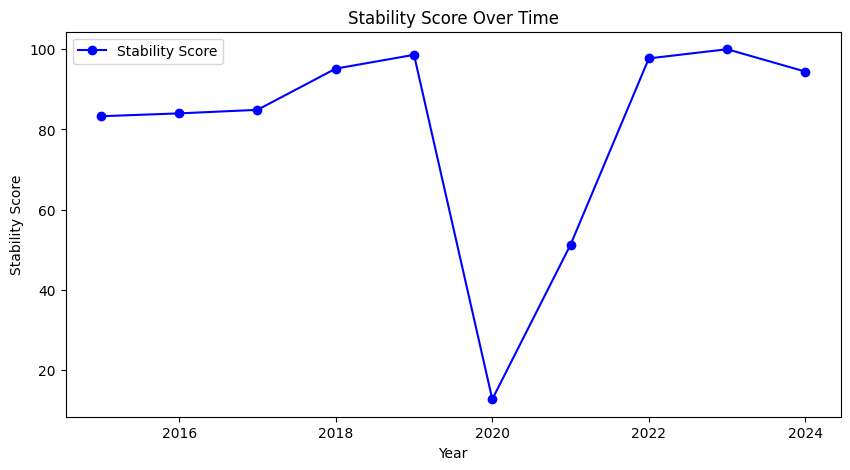

In [30]:
# Extract Layoff and Quit Rates
stability_series = ["LNU03023653Q", "LNU03023705Q"]  # Layoffs & Quit Rates
df_stability = df[df["Series ID"].isin(stability_series)].copy()

# Convert values to numeric
df_stability["Value"] = pd.to_numeric(df_stability["Value"], errors="coerce")

# Extract Year
df_stability["Year"] = df_stability["Date"].dt.year

# Aggregate by Year
df_stability = df_stability.groupby("Year")["Value"].sum().reset_index()

# Compute Stability Score (Inverse Relationship to Layoffs + Quits)
df_stability["Stability Score"] = 1 / (1 + df_stability["Value"])  # Lower layoffs & quits → Higher stability

# Normalize Stability Score (Scale 0-100)
df_stability["Stability Score"] = (df_stability["Stability Score"] / df_stability["Stability Score"].max()) * 100

# Keep only Year & Stability Score
df_stability = df_stability[["Year", "Stability Score"]]

# Display Stability Score Data
print(df_stability.head())

# Stability by year
plt.figure(figsize=(10, 5))
plt.plot(df_stability["Year"], df_stability["Stability Score"], marker="o", linestyle="-", color="b", label="Stability Score")

# Axis Labels with Explanation
plt.xlabel("Year")
plt.ylabel("Stability Score")
plt.title("Stability Score Over Time")
plt.legend()
plt.grid(False)

# Show Plot
plt.show()

Estimate Job Openings & Hires by Industry

In [31]:
# 1️⃣ Compute Wage Growth Per Industry (Used for Allocation)
df_wage_growth = df_wages_filtered.groupby("Industry")["Value"].pct_change().groupby(df_wages_filtered["Industry"]).mean().reset_index()
df_wage_growth.rename(columns={"Value": "Wage Growth"}, inplace=True)

# Normalize Wage Growth to use as a distribution factor
df_wage_growth["Normalized Growth"] = df_wage_growth["Wage Growth"] / df_wage_growth["Wage Growth"].sum()

# 2️⃣ Allocate Job Openings & Hires Based on Wage Growth
df_job_openings["Industry"] = df_wage_growth["Industry"]  # Map industries
df_hires["Industry"] = df_wage_growth["Industry"]

df_job_openings["Job Openings (Industry)"] = df_job_openings["Total Job Openings (in thousands)"] * df_wage_growth["Normalized Growth"]
df_hires["Hires (Industry)"] = df_hires["Total Hires (in thousands)"] * df_wage_growth["Normalized Growth"]

print(df_wage_growth.head())
print(df_job_openings.head())
print(df_hires.head())

                                            Industry  Wage Growth  \
0  Average Hourly Earnings (Production & Nonsuper...     0.003066   
1            Average Hourly Earnings (Total Private)     0.002846   
2             Construction – Average Hourly Earnings     0.002801   
3     Financial Activities – Average Hourly Earnings     0.003142   
4               Healthcare – Average Hourly Earnings     0.002526   

   Normalized Growth  
0           0.090539  
1           0.084034  
2           0.082713  
3           0.092781  
4           0.074603  
   Year  Total Job Openings (in thousands)  \
0  2015                            66766.0   
1  2016                            70266.0   
2  2017                            73422.0   
3  2018                            85310.0   
4  2019                            85846.0   

                                            Industry  Job Openings (Industry)  
0  Average Hourly Earnings (Production & Nonsuper...              6044.899126  
1         

Estimate Stability Score by Industry

                                            Industry  Wage Volatility  \
0  Average Hourly Earnings (Production & Nonsuper...         3.076593   
1            Average Hourly Earnings (Total Private)         3.353100   
2             Construction – Average Hourly Earnings         3.491518   
3     Financial Activities – Average Hourly Earnings         4.682488   
4               Healthcare – Average Hourly Earnings         3.103829   

   Stability Score  
0        81.220715  
1        74.523001  
2        71.568622  
3        53.365452  
4        80.508009  


<ipython-input-32-2f7496b2f501>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_stable, x="Industry", y="Stability Score", palette="coolwarm")


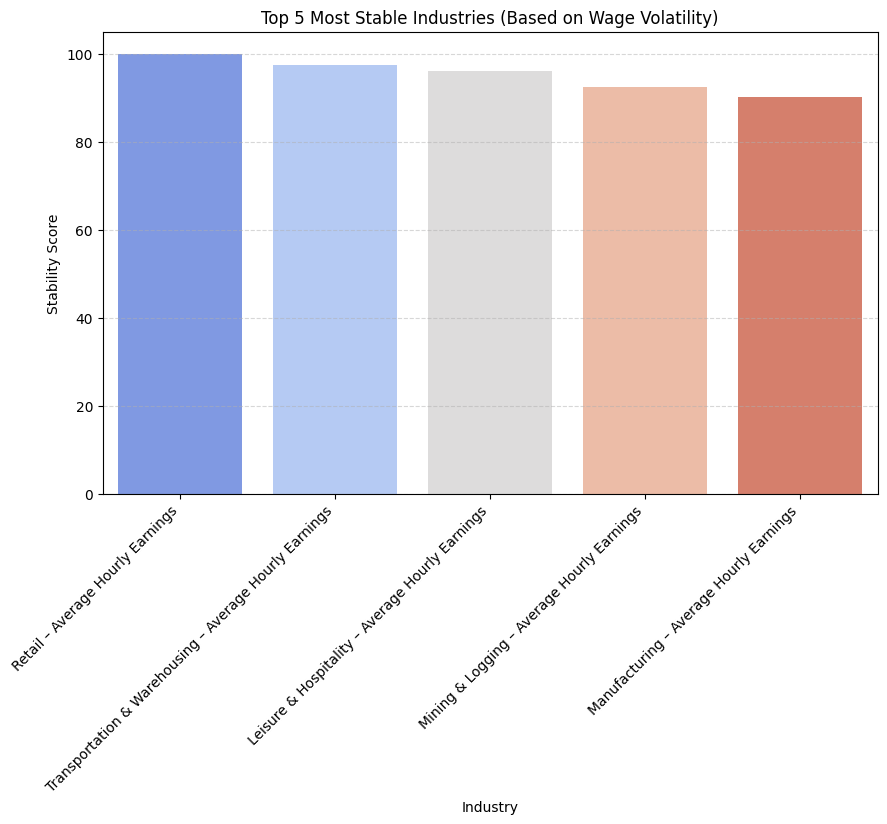

In [32]:
# Compute wage volatility per industry (standard deviation of wages)
df_wage_volatility = df_wages_filtered.groupby("Industry")["Value"].std().reset_index()
df_wage_volatility.rename(columns={"Value": "Wage Volatility"}, inplace=True)

# Normalize & invert stability score
df_wage_volatility["Stability Score"] = (1 / df_wage_volatility["Wage Volatility"]) * 100
df_wage_volatility["Stability Score"] = df_wage_volatility["Stability Score"] / df_wage_volatility["Stability Score"].max() * 100

print(df_wage_volatility.head())

# Sort industries by highest stability score
top_5_stable = df_wage_volatility.nlargest(5, "Stability Score")

# Plot Stability Score for top 5 industries
plt.figure(figsize=(10, 6))
sns.barplot(data=top_5_stable, x="Industry", y="Stability Score", palette="coolwarm")

# Formatting
plt.xticks(rotation=45, ha="right")
plt.xlabel("Industry")
plt.ylabel("Stability Score")
plt.title("Top 5 Most Stable Industries (Based on Wage Volatility)")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show plot
plt.show()

Estimate Education ROI by Industry

In [33]:
# **1️⃣ Ensure Industry Data is Available in Wages Data**
df_wages_filtered = df_wages_filtered[["Industry", "Value"]].copy()

# **2️⃣ Compute Industry-Specific Average Wages**
df_avg_wages = df_wages_filtered.groupby("Industry")["Value"].mean().reset_index()
df_avg_wages.rename(columns={"Value": "Avg Wage"}, inplace=True)

# **3️⃣ Define Education Cost Multipliers for Each Industry**
edu_costs = {
    "Manufacturing – Average Hourly Earnings": 1.0,
    "Retail – Average Hourly Earnings": 0.8,
    "Healthcare – Average Hourly Earnings": 1.5,
    "Construction – Average Hourly Earnings": 1.0,
    "Information Technology (IT) – Average Hourly Earnings": 1.2,
    "Financial Activities – Average Hourly Earnings": 1.3,
    "Professional & Business Services – Average Hourly Earnings": 1.1,
    "Education – Average Hourly Earnings": 1.7,
    "Leisure & Hospitality – Average Hourly Earnings": 0.6,
    "Transportation & Warehousing – Average Hourly Earnings": 0.9,
    "Mining & Logging – Average Hourly Earnings": 1.4,
    "Average Hourly Earnings (Total Private)": 1.0,
    "Average Hourly Earnings (Production & Nonsupervisory Employees)": 0.9
}

# **4️⃣ Ensure Unique Industry Data**
df_edu_roi = df_avg_wages.copy()
df_edu_roi["Education Cost"] = df_edu_roi["Industry"].map(edu_costs)

# **5️⃣ Compute Education ROI = Wage / Education Cost**
df_edu_roi["Education ROI"] = df_edu_roi["Avg Wage"] / df_edu_roi["Education Cost"]

# **6️⃣ Handle NaN Values for Industries Without Education Cost Data**
df_edu_roi["Education ROI"].fillna(df_edu_roi["Education ROI"].mean(), inplace=True)

# **7️⃣ Normalize Education ROI (0-100)**
df_edu_roi["Education ROI"] = df_edu_roi["Education ROI"] / df_edu_roi["Education ROI"].max() * 100

print(df_edu_roi.head())

                                            Industry   Avg Wage  \
0  Average Hourly Earnings (Production & Nonsuper...  24.803083   
1            Average Hourly Earnings (Total Private)  29.308333   
2             Construction – Average Hourly Earnings  31.894917   
3     Financial Activities – Average Hourly Earnings  37.625333   
4               Healthcare – Average Hourly Earnings  29.234250   

   Education Cost  Education ROI  
0             0.9      77.697049  
1             1.0      82.628998  
2             1.0      89.921353  
3             1.3      81.597784  
4             1.5      54.946756  


<ipython-input-33-30014a1ab1b5>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_edu_roi["Education ROI"].fillna(df_edu_roi["Education ROI"].mean(), inplace=True)


In [34]:
# Merge all industry-wise data
df_ranking = df_wage_growth.merge(df_job_openings[["Industry", "Job Openings (Industry)"]], on="Industry")
df_ranking = df_ranking.merge(df_hires[["Industry", "Hires (Industry)"]], on="Industry")
df_ranking = df_ranking.merge(df_wage_volatility[["Industry", "Stability Score"]], on="Industry")
df_ranking = df_ranking.merge(df_edu_roi[["Industry", "Education ROI"]], on="Industry")

# Normalize all scores (0-100)
#for col in ["Wage Growth", "Job Openings (Industry)", "Hires (Industry)", "Stability Score", "Education ROI"]:
#    df_ranking[col] = (df_ranking[col] - df_ranking[col].min()) / (df_ranking[col].max() - df_ranking[col].min()) * 100

# Compute Final Score
df_ranking["Final Score"] = (
    df_ranking["Wage Growth"] * 0.30 +
    df_ranking["Job Openings (Industry)"] * 0.25 +
    df_ranking["Stability Score"] * 0.20 +
    df_ranking["Education ROI"] * 0.25
)

# Create a normalized version of Final Score
df_ranking["Final Score (Normalized)"] = (df_ranking["Final Score"] - df_ranking["Final Score"].min()) / \
                                         (df_ranking["Final Score"].max() - df_ranking["Final Score"].min()) * 100

# Order the table by Final Score (Normalized) in descending order
df_ranking = df_ranking.sort_values(by="Final Score (Normalized)", ascending=False)

# Display the updated ranking table
print(df_ranking.head(5))

                                            Industry  Wage Growth  \
6    Leisure & Hospitality – Average Hourly Earnings     0.003823   
7            Manufacturing – Average Hourly Earnings     0.002424   
9  Professional & Business Services – Average Hou...     0.002863   
3     Financial Activities – Average Hourly Earnings     0.003142   
8         Mining & Logging – Average Hourly Earnings     0.002013   

   Normalized Growth  Job Openings (Industry)  Hires (Industry)  \
6           0.112886             13527.177522        718.302171   
7           0.071591              9610.540204        458.645694   
9           0.084529              8158.255834        465.100328   
3           0.092781              7915.120483        531.856587   
8           0.059440              6669.835937        351.312694   

   Stability Score  Education ROI  Final Score  Final Score (Normalized)  
6        95.963296      82.735113  3421.671965                100.000000  
7        90.224666      81.24848

Importing Skills Data

In [105]:
import pandas as pd

# Google Sheets URL (Update with your actual URL)
sheet_url = "https://docs.google.com/spreadsheets/d/15GG1ILgxzkatUWTXisGUUUUTnfQt6tmo/edit#gid=692765393"

# Convert to a CSV export link
csv_export_url = sheet_url.replace("/edit#gid=", "/gviz/tq?tqx=out:csv&gid=")

# Read the Google Sheet into a DataFrame
df_skills = pd.read_csv(csv_export_url,skiprows =1, header=None)

df_skills.columns = [
    "Occupation", "SOC Code", "Employment 2023", "Employment 2033", "Employment Change (Numeric)",
    "Employment Change (%)", "Median Annual Wage", "Education Needed",
    "Adaptability", "Computers & IT", "Creativity & Innovation", "Critical Thinking",
    "Customer Service", "Detail Oriented", "Fine Motor", "Interpersonal",
    "Leadership", "Mathematics", "Mechanical", "Physical Strength & Stamina",
    "Problem Solving", "Project Management", "Science", "Speaking & Listening", "Writing & Reading"
]

# Display first few rows
print(df_skills.head())

                              Occupation SOC Code Employment 2023  \
0                 Total, all occupations  00-0000       167,849.8   
1                       Chief executives  11-1011           313.9   
2        General and operations managers  11-1021         3,630.1   
3                         Legislators[2]  11-1031            33.7   
4    Advertising and promotions managers  11-2011            22.2   

  Employment 2033 Employment Change (Numeric)  Employment Change (%)  \
0       174,589.0                     6,739.2                    4.0   
1           331.1                        17.2                    5.5   
2         3,840.5                       210.4                    5.8   
3            35.0                         1.4                    4.1   
4            21.7                        -0.6                   -2.6   

  Median Annual Wage   Education Needed  Adaptability  Computers & IT  ...  \
0             48,060                  —           3.8             3.0  ...

In [107]:
# Drop unnecessary rows (like "Total, all occupations")
df_skills = df_skills[df_skills["SOC Code"] != "00-0000"]

# Convert numeric columns to float
numeric_cols = [
    "Employment 2023", "Employment 2033", "Employment Change (Numeric)", "Employment Change (%)",
    "Median Annual Wage", "Adaptability", "Computers & IT", "Critical Thinking", "Customer Service",
    "Interpersonal", "Leadership", "Mathematics", "Mechanical", "Physical Strength & Stamina",
    "Problem Solving", "Project Management", "Science", "Speaking & Listening", "Writing & Reading"
]
df_skills[numeric_cols] = df_skills[numeric_cols].replace(",", "", regex=True).astype(float)

# Display cleaned data
print(df_skills.head())

                              Occupation SOC Code  Employment 2023  \
1                       Chief executives  11-1011            313.9   
2        General and operations managers  11-1021           3630.1   
3                         Legislators[2]  11-1031             33.7   
4    Advertising and promotions managers  11-2011             22.2   
5                     Marketing managers  11-2021            389.1   

   Employment 2033  Employment Change (Numeric)  Employment Change (%)  \
1            331.1                         17.2                    5.5   
2           3840.5                        210.4                    5.8   
3             35.0                          1.4                    4.1   
4             21.7                         -0.6                   -2.6   
5            420.8                         31.7                    8.2   

   Median Annual Wage   Education Needed  Adaptability  Computers & IT  ...  \
1            206680.0  Bachelor's degree           4.2 

Mapping Occupations to Industry

In [139]:
import re

# Define a dictionary mapping occupation keywords to industry titles
industry_mapping = {
    # Strong matches
    "Manufacturing|Production|Industrial|Factory|Assembler|Machinist|Fabricator": "Manufacturing – Average Hourly Earnings",
    "Retail|Sales|Cashier|Merchandiser|Store|Buyer|Customer": "Retail – Average Hourly Earnings",
    "Healthcare|Medical|Nurse|Doctor|Therapist|Surgeon|Dentist|Pharmacist|Veterinarian|Hospital": "Healthcare – Average Hourly Earnings",
    "Construction|Builder|Carpenter|Plumber|Electrician|Engineering Technician|Surveyor|Welder": "Construction – Average Hourly Earnings",
    "Software|Information|Computer|IT|Developer|Programmer|Data|Cyber|Network|AI|Cloud|Systems Analyst|Software Engineer": "Information Technology (IT) – Average Hourly Earnings",
    "Finance|Accounting|Banking|Auditor|Economist|Insurance|Actuary|Analyst|Investment|Tax|Treasurer": "Financial Activities – Average Hourly Earnings",
    "Business|Consulting|Management|Logistician|Project Manager|Executive|Marketing|HR|Operations|Recruiter|Administrator|Strategy": "Professional & Business Services – Average Hourly Earnings",
    "Education|Teacher|Professor|Instructor|Librarian|Counselor|Trainer|Educator|Academia": "Education – Average Hourly Earnings",
    "Hospitality|Restaurant|Hotel|Food Service|Chef|Bartender|Waiter|Lodging|Catering|Resort|Baker": "Leisure & Hospitality – Average Hourly Earnings",
    "Logistics|Transport|Warehousing|Supply Chain|Truck Driver|Shipping|Distribution|Courier|Freight": "Transportation & Warehousing – Average Hourly Earnings",
    "Mining|Logging|Oil|Gas|Geologist|Petroleum|Drilling|Energy|Renewable": "Mining & Logging – Average Hourly Earnings",
    "Legal|Lawyer|Attorney|Paralegal|Judge|Court Reporter|Legal Analyst": "Legal – Average Hourly Earnings",
    "Security|Firefighter|Police|Correctional|Detective|Guard|Investigator|Emergency Responder|Homeland Security": "Security & Protective Services – Average Hourly Earnings",
    "Science|Biologist|Chemist|Physicist|Researcher|Environmental|Geologist|Pharmacologist|Ecologist|Zoologist|Astronomer|Geneticist": "Science & Research – Average Hourly Earnings",
    "Entertainment|Arts|Music|Actor|Writer|Performer|Producer|Director|Designer|Animator|Fashion": "Arts & Entertainment – Average Hourly Earnings",
    "Government|Public Administration|Policy Analyst|Urban Planner|Regulatory|Inspector": "Government & Public Sector – Average Hourly Earnings",
    "Social Work|Nonprofit|Community Service|Human Services|Social Worker|Psychologist|Therapist|Advocate": "Social Services – Average Hourly Earnings",
    "Energy|Utilities|Renewable|Power Plant|Nuclear|Wind|Solar|Hydropower": "Energy & Utilities – Average Hourly Earnings",
}

# Function to map occupations to industries
def assign_industry(occupation):
    for keyword, industry in industry_mapping.items():
        if re.search(keyword, occupation, re.IGNORECASE):  # Case-insensitive regex search
            return industry
    return "Other"  # Assign "Other" if no match is found

# Apply mapping function to create a new "Industry" column
df_skills["Industry"] = df_skills["Occupation"].apply(assign_industry)

# Check the mapping results
print(df_skills["Industry"].value_counts())

# Define the list of skill-related columns
skill_columns = [
    "Adaptability", "Computers & IT", "Creativity & Innovation", "Critical Thinking",
    "Customer Service", "Detail Oriented", "Fine Motor", "Interpersonal",
    "Leadership", "Mathematics", "Mechanical", "Physical Strength & Stamina",
    "Problem Solving", "Project Management", "Science", "Speaking & Listening", "Writing & Reading"
]

# Apply mapping function to create a new "Industry" column
df_skills["Industry"] = df_skills["Occupation"].apply(assign_industry)
df_skills["Industry"] = df_skills["Industry"].fillna("Other")

print(df_skills.head())
# Merge skills dataset with wage dataset on "Industry"
df_skills_wages = df_skills.merge(df_industry, left_on="Industry", right_on="Series Title", how="left")
print(df_skills_wages.head())

# Compute mean skill importance across all occupations
avg_skill_importance = df_skills_wages[skill_columns].mean().sort_values(ascending=False)

# Convert to DataFrame for visualization
df_skill_rankings = avg_skill_importance.reset_index()
df_skill_rankings.columns = ["Skill", "Average Importance"]

print(df_skill_rankings.head())

# Find the top 10 highest-paying jobs
# Find the top 10 highest-paying jobs
df_top_jobs = df_skills.sort_values(by="Median Annual Wage", ascending=False).head(10)

# Select relevant columns for analysis, ensuring "Industry" is included
df_top_jobs = df_top_jobs[["Industry", "Occupation", "Median Annual Wage"] + skill_columns]

# Display top jobs DataFrame
print(df_top_jobs.head())

# Define industries of interest
industries = ["Software", "Healthcare", "Manufacturing", "Finance", "Engineering"]

# Filter occupations based on industry keywords
df_industry_skills = df_skills[df_skills["Occupation"].str.contains("|".join(industries), na=False, case=False)]

print(df_industry_skills.head())

Industry
Other                                                         375
Information Technology (IT) – Average Hourly Earnings         172
Education – Average Hourly Earnings                            51
Healthcare – Average Hourly Earnings                           45
Manufacturing – Average Hourly Earnings                        22
Mining & Logging – Average Hourly Earnings                     22
Construction – Average Hourly Earnings                         19
Professional & Business Services – Average Hourly Earnings     18
Science & Research – Average Hourly Earnings                   18
Retail – Average Hourly Earnings                               18
Arts & Entertainment – Average Hourly Earnings                 14
Security & Protective Services – Average Hourly Earnings       12
Leisure & Hospitality – Average Hourly Earnings                10
Financial Activities – Average Hourly Earnings                 10
Transportation & Warehousing – Average Hourly Earnings          9
E

In [138]:
print(df_top_jobs.columns)

Index(['Occupation', 'SOC Code', 'Employment 2023', 'Employment 2033',
       'Employment Change (Numeric)', 'Employment Change (%)',
       'Median Annual Wage', 'Education Needed', 'Adaptability',
       'Computers & IT', 'Creativity & Innovation', 'Critical Thinking',
       'Customer Service', 'Detail Oriented', 'Fine Motor', 'Interpersonal',
       'Leadership', 'Mathematics', 'Mechanical',
       'Physical Strength & Stamina', 'Problem Solving', 'Project Management',
       'Science', 'Speaking & Listening', 'Writing & Reading', 'Industry_x_x',
       'Series ID', 'Value', 'Date', 'Series Title', 'Year', 'Month',
       'Month_Year', 'Industry_y', 'Indexed_Wage', 'Industry_x_y',
       'Industry_x'],
      dtype='object')


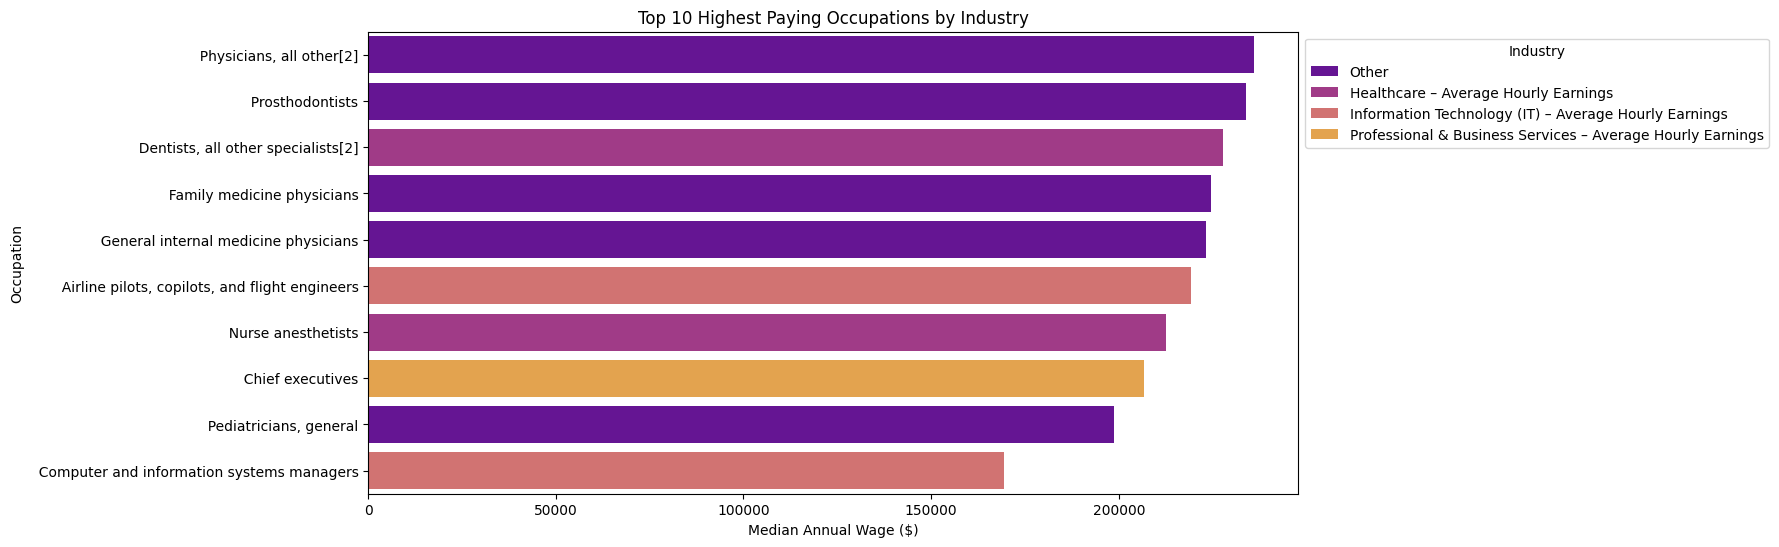

In [146]:
# Ensure 'Industry' is correctly included
if "Industry" not in df_top_jobs.columns:
    df_top_jobs = df_top_jobs.merge(df_skills_wages[["Occupation", "Industry"]], on="Occupation", how="left")

# Drop missing industry values
df_top_jobs = df_top_jobs.dropna(subset=["Industry"])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_jobs, x="Median Annual Wage", y="Occupation", hue="Industry", palette="plasma")
plt.xlabel("Median Annual Wage ($)")
plt.ylabel("Occupation")
plt.title("Top 10 Highest Paying Occupations by Industry")
plt.grid(False)
plt.legend(title="Industry", bbox_to_anchor=(1,1))
plt.show()

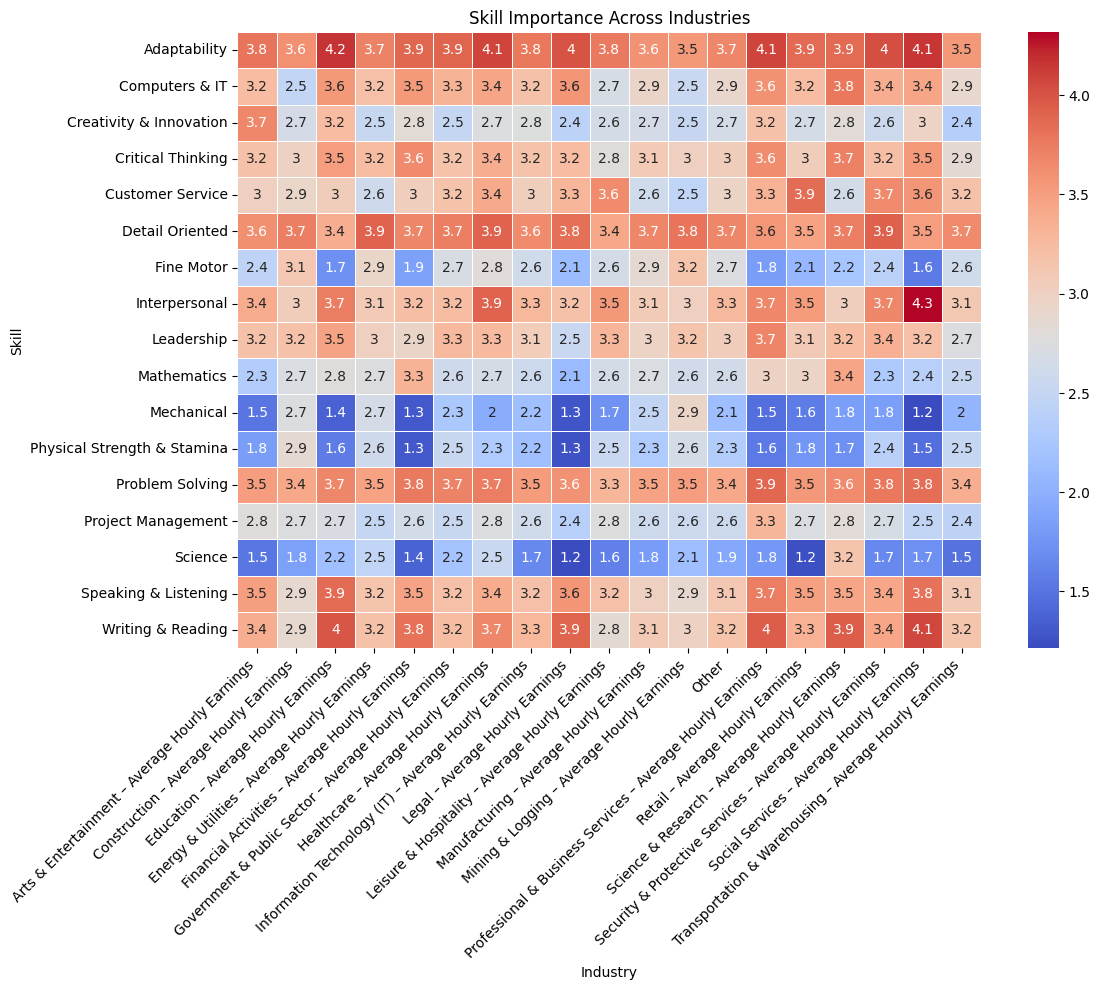

In [131]:
if "Industry" not in df_skills_wages.columns:
    df_skills_wages = df_skills_wages.merge(df_skills[["Occupation", "Industry"]], on="Occupation", how="left")

# Check for missing values in "Industry"
df_skills_wages = df_skills_wages.dropna(subset=["Industry"])

# Group by Industry and calculate mean skill importance
df_industry_skills = df_skills_wages.groupby("Industry")[skill_columns].mean()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_industry_skills.T, cmap="coolwarm", linewidths=0.5, annot=True)
plt.title("Skill Importance Across Industries")
plt.xlabel("Industry")
plt.ylabel("Skill")
plt.xticks(rotation=45, ha="right")
plt.show()


<ipython-input-149-7073b380eab7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_employment_growth.values, y=df_employment_growth.index, palette="viridis")


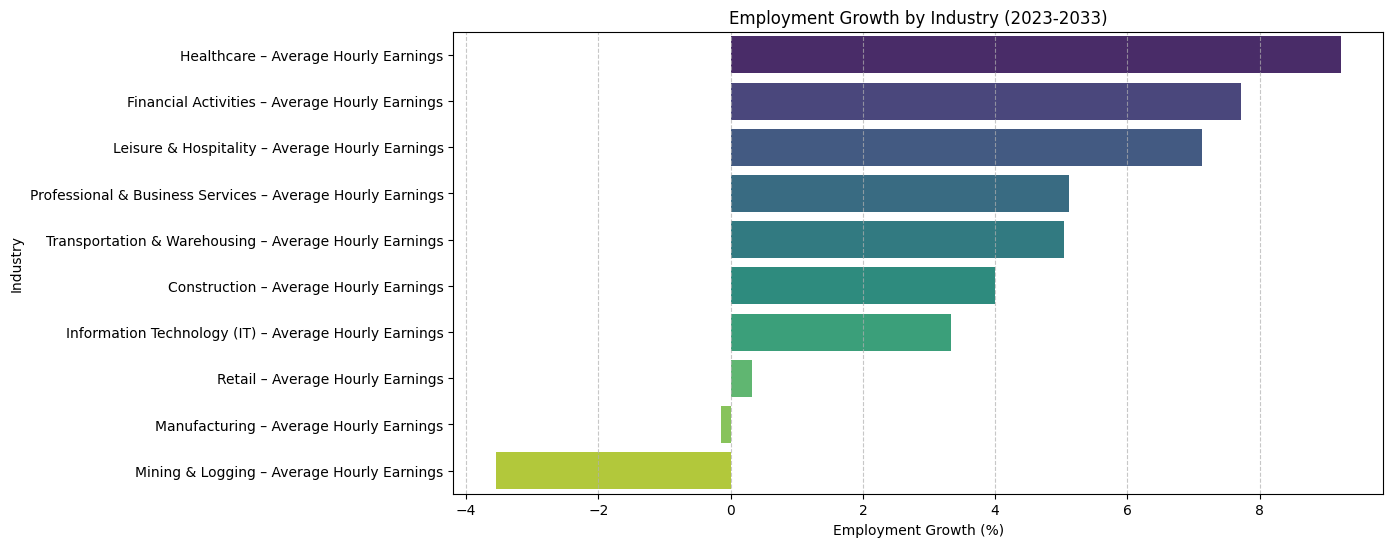

In [149]:
# Aggregate employment change by industry
df_employment_growth = df_skills_wages.groupby("Series Title")["Employment Change (%)"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=df_employment_growth.values, y=df_employment_growth.index, palette="viridis")
plt.xlabel("Employment Growth (%)")
plt.ylabel("Industry")
plt.title("Employment Growth by Industry (2023-2033)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()
